# **Homework 1: COVID-19 Cases Prediction (Regression)**

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Familiarize yourself with PyTorch.

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2022-spring@googlegroups.com

# Download data
If the Google Drive links below do not work, you can download data from [Kaggle](https://www.kaggle.com/t/a3ebd5b5542f0f55e828d4f00de8e59a), and upload data manually to the workspace.

!gdown --id '1kLSW_-cW2Huj7bh84YTdimGBOJaODiOS' --output covid.train.csv
!gdown --id '1iiI5qROrAhZn-o4FPqsE97bMzDEFvIdg' --output covid.test.csv

# Import packages

In [1]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

# 新添加这两行用于数据分析可视化
import matplotlib.pyplot as plt
import seaborn as sns

# 在你现有的import后面添加这几行
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import Ridge

In [2]:
df = pd.read_csv('covid.train.csv',index_col=0)
test_df = pd.read_csv('covid.test.csv',index_col=0)

# Some Utility Functions

You do not need to modify this part.

In [5]:
def same_seed(seed):
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set))
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    return preds

# Dataset

Dataset类包装 → 变成PyTorch能理解的格式，提供索引访问
- def __init__(self, x, y=None):     # ✅ 存储数据
- def __getitem__(self, idx):       # ✅ 提供"按索引取数据"的能力  
- def __len__(self):            # ✅ 提供"数据总数"的信息

In [6]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Neural Network Model
Try out different model architectures by modifying the class below.

In [7]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        # 改进的网络结构
        self.net = nn.Sequential(
            # nn.Linear(input_dim, 64),
            # ReLU换成LeakyReLU解决了ReLU的dying neuron问题
            # nn.LeakyReLU(), #新增，参考激活函数对比
            # nn.BatchNorm1d(64),
            # nn.Dropout(p=0.2),
            # nn.Linear(64, 1)
            #2
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
        # 将损失函数移到模型内部
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        # 使用RMSE而不是MSE
        return torch.sqrt(self.criterion(pred, target))

# Feature Selection
Choose features you deem useful by modifying the function below.

In [8]:
def select_feat(train_data, valid_data, test_data, select_all=True, use_simple_selection=False):
    '''简化特征选择：只用4个最重要的特征'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
        return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid
    
    elif use_simple_selection:
        print("🎯 使用简化特征选择：只保留4个最重要的特征")
        
        # 数据结构分析：
        # id(1列) + 州特征(37列) + 时间序列特征(5个时间段 × 16特征)
        # 我们要选择前4天的：tested_positive, ili, cli, hh_cmnty_cli
        
        feature_positions = []
        
        # 根据列名顺序，每个时间段的特征顺序应该是：
        # cli, ili, hh_cmnty_cli, nohh_cmnty_cli, wearing_mask, travel_outside_state, 
        # work_outside_home, shop, restaurant, spent_time, large_event, public_transit, 
        # anxious, depressed, worried_finances, tested_positive
        
        # 选择前4个时间段的4个关键特征
        for time_period in range(4):  # 前4天
            base_start = 38 + time_period * 16  # 38 = 1(id) + 37(州特征)
            
            # 每个时间段选择的特征位置：
            period_features = [
                base_start + 15,  # tested_positive (最后一个位置)
                base_start + 1,   # ili (第2个位置)  
                base_start + 0,   # cli (第1个位置)
                base_start + 2,   # hh_cmnty_cli (第3个位置)
            ]
            feature_positions.extend(period_features)
        
        print(f"✅ 选择特征数量：{len(feature_positions)} (4天 × 4特征)")
        print("✅ 选择的特征：tested_positive, ili, cli, hh_cmnty_cli (前4天)")
        
        return (raw_x_train[:,feature_positions], 
                raw_x_valid[:,feature_positions], 
                raw_x_test[:,feature_positions], 
                y_train, y_valid)
    
    else:
        # 更简单的版本：如果上面的位置不对，手动指定
        print("🎯 使用超简化特征选择：手动指定关键位置")
        
        # 这里我们保守一点，先选择一些明确知道的高相关性特征位置
        # 你可以根据实际数据调整这些位置
        feat_idx = []
        
        # 从每个时间段选择最重要的几个特征
        for period in range(4):  # 前4个时间段
            start_pos = 38 + period * 16
            # 选择每个时间段的前几个特征（通常cli, ili等在前面）
            feat_idx.extend([start_pos, start_pos+1, start_pos+2, start_pos+15])
        
        print(f"✅ 保守选择：{len(feat_idx)} 个特征位置")
        return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

# Training Loop

In [9]:
def trainer(train_loader, valid_loader, test_loader, model, config, device):
    """修改后的训练函数，添加了测试损失监控"""
    
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
    writer = SummaryWriter()

    if not os.path.isdir('./models'):
        os.mkdir('./models')
    
    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    train_losses, val_losses = [], [] 

    for epoch in range(n_epochs):
        model.train()
        loss_record = []

        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = model.cal_loss(pred, y)
            loss.backward()
            optimizer.step()
            step += 1
            loss_record.append(loss.detach().item())

            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        # 验证集评估
        model.eval()
        valid_loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = model.cal_loss(pred, y)
            valid_loss_record.append(loss.item())

        mean_valid_loss = sum(valid_loss_record)/len(valid_loss_record)
        writer.add_scalar('Loss/valid', mean_valid_loss, step)
        
        # 测试集评估（每10个epoch评估一次，避免过于频繁）
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            test_loss_record = []
            for x in test_loader:  # 注意：测试集没有标签，这里我们用验证集代替来演示
                pass
            
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        
        train_losses.append(mean_train_loss)
        val_losses.append(mean_valid_loss)  

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path'])
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return train_losses, val_losses
        return train_losses, val_losses    

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'select_all': False,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 3000,     # Number of epochs.3000
    'batch_size': 256,
    'learning_rate': 1e-2,
    'early_stop': 200,    # If model has not improved for this many consecutive epochs, stop training.
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'select_all': False,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 3000,     # Number of epochs.3000
    'batch_size': 256,
    'learning_rate': 1e-3,
    'early_stop': 400,    # If model has not improved for this many consecutive epochs, stop training.
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

# Dataloader
Read data from files and set up training, validation, and testing sets. You do not need to modify this part.

In [11]:
# Set seed for reproducibility
same_seed(config['seed'])


# train_data size: 2699 x 118 (id + 37 states + 16 features x 5 days)
# test_data size: 1078 x 117 (without last day's positive rate)
train_data, test_data = pd.read_csv('./covid.train.csv').values, pd.read_csv('./covid.test.csv').values
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

# Print out the data size.
print(f"""train_data size: {train_data.shape}
valid_data size: {valid_data.shape}
test_data size: {test_data.shape}""")

# Select features
#x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, config['select_all'])
# Select features
x_train, x_valid, x_test, y_train, y_valid = select_feat(
    train_data, valid_data, test_data, 
    select_all=False,              # 👈 不使用全部特征
    use_simple_selection=True      # 👈 使用简化的4特征选择
)
# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

# test_dataset = COVID19Dataset(x_test)  # x_test的维度必须匹配训练时的维度
train_dataset, valid_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                            COVID19Dataset(x_valid, y_valid), \
                                            COVID19Dataset(x_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

train_data size: (2160, 118)
valid_data size: (539, 118)
test_data size: (1078, 117)
🎯 使用简化特征选择：只保留4个最重要的特征
✅ 选择特征数量：16 (4天 × 4特征)
✅ 选择的特征：tested_positive, ili, cli, hh_cmnty_cli (前4天)
number of features: 16


# Start training!

In [12]:
model = My_Model(input_dim=x_train.shape[1]).to(device)
train_losses, val_losses = trainer(train_loader, valid_loader, model, config, device)

D:\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch [1/3000]: 100%|██████████| 9/9 [00:00<00:00, 82.54it/s, loss=11.5]


Epoch [1/3000]: Train loss: 13.0876, Valid loss: 11.8025
Saving model with loss 11.802...


Epoch [2/3000]: 100%|██████████| 9/9 [00:00<00:00, 81.50it/s, loss=12.6]


Epoch [2/3000]: Train loss: 11.6709, Valid loss: 11.9560


Epoch [3/3000]: 100%|██████████| 9/9 [00:00<00:00, 97.99it/s, loss=10.2]


Epoch [3/3000]: Train loss: 10.8650, Valid loss: 9.4543
Saving model with loss 9.454...


Epoch [4/3000]: 100%|██████████| 9/9 [00:00<00:00, 83.07it/s, loss=5.31]


Epoch [4/3000]: Train loss: 5.9261, Valid loss: 5.3190
Saving model with loss 5.319...


Epoch [5/3000]: 100%|██████████| 9/9 [00:00<00:00, 87.14it/s, loss=2.99]


Epoch [5/3000]: Train loss: 3.7921, Valid loss: 2.8807
Saving model with loss 2.881...


Epoch [6/3000]: 100%|██████████| 9/9 [00:00<00:00, 74.00it/s, loss=2.81]


Epoch [6/3000]: Train loss: 2.6199, Valid loss: 2.5907
Saving model with loss 2.591...


Epoch [7/3000]: 100%|██████████| 9/9 [00:00<00:00, 129.07it/s, loss=1.94]


Epoch [7/3000]: Train loss: 2.1930, Valid loss: 2.2921
Saving model with loss 2.292...


Epoch [8/3000]: 100%|██████████| 9/9 [00:00<00:00, 132.75it/s, loss=1.49]


Epoch [8/3000]: Train loss: 1.8858, Valid loss: 1.9019
Saving model with loss 1.902...


Epoch [9/3000]: 100%|██████████| 9/9 [00:00<00:00, 96.18it/s, loss=1.47]


Epoch [9/3000]: Train loss: 1.6815, Valid loss: 1.7126
Saving model with loss 1.713...


Epoch [10/3000]: 100%|██████████| 9/9 [00:00<00:00, 101.01it/s, loss=1.6]


Epoch [10/3000]: Train loss: 1.5180, Valid loss: 1.5405
Saving model with loss 1.541...


Epoch [11/3000]: 100%|██████████| 9/9 [00:00<00:00, 101.98it/s, loss=1.41]


Epoch [11/3000]: Train loss: 1.4438, Valid loss: 1.5650


Epoch [12/3000]: 100%|██████████| 9/9 [00:00<00:00, 119.73it/s, loss=1.44]


Epoch [12/3000]: Train loss: 1.3871, Valid loss: 1.5360
Saving model with loss 1.536...


Epoch [13/3000]: 100%|██████████| 9/9 [00:00<00:00, 95.58it/s, loss=1.42]


Epoch [13/3000]: Train loss: 1.3373, Valid loss: 1.4159
Saving model with loss 1.416...


Epoch [14/3000]: 100%|██████████| 9/9 [00:00<00:00, 92.59it/s, loss=1.44]


Epoch [14/3000]: Train loss: 1.3153, Valid loss: 1.5027


Epoch [15/3000]: 100%|██████████| 9/9 [00:00<00:00, 111.46it/s, loss=1.36]


Epoch [15/3000]: Train loss: 1.3048, Valid loss: 1.3693
Saving model with loss 1.369...


Epoch [16/3000]: 100%|██████████| 9/9 [00:00<00:00, 98.77it/s, loss=1.32]


Epoch [16/3000]: Train loss: 1.2748, Valid loss: 1.3566
Saving model with loss 1.357...


Epoch [17/3000]: 100%|██████████| 9/9 [00:00<00:00, 95.10it/s, loss=1.2]


Epoch [17/3000]: Train loss: 1.2262, Valid loss: 1.3085
Saving model with loss 1.309...


Epoch [18/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.00it/s, loss=1.24]


Epoch [18/3000]: Train loss: 1.2001, Valid loss: 1.2382
Saving model with loss 1.238...


Epoch [19/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.75it/s, loss=1.34]


Epoch [19/3000]: Train loss: 1.1883, Valid loss: 1.1845
Saving model with loss 1.185...


Epoch [20/3000]: 100%|██████████| 9/9 [00:00<00:00, 126.90it/s, loss=1.27]


Epoch [20/3000]: Train loss: 1.1615, Valid loss: 1.2151


Epoch [21/3000]: 100%|██████████| 9/9 [00:00<00:00, 111.24it/s, loss=1.2]


Epoch [21/3000]: Train loss: 1.1685, Valid loss: 1.5380


Epoch [22/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.92it/s, loss=1.32]


Epoch [22/3000]: Train loss: 1.2077, Valid loss: 1.1711
Saving model with loss 1.171...


Epoch [23/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.33it/s, loss=0.962]


Epoch [23/3000]: Train loss: 1.1355, Valid loss: 1.2403


Epoch [24/3000]: 100%|██████████| 9/9 [00:00<00:00, 103.85it/s, loss=1.04]


Epoch [24/3000]: Train loss: 1.1973, Valid loss: 1.2680


Epoch [25/3000]: 100%|██████████| 9/9 [00:00<00:00, 375.47it/s, loss=1.19]


Epoch [25/3000]: Train loss: 1.2490, Valid loss: 1.1841


Epoch [26/3000]: 100%|██████████| 9/9 [00:00<00:00, 411.78it/s, loss=1.2]


Epoch [26/3000]: Train loss: 1.1702, Valid loss: 1.3980


Epoch [27/3000]: 100%|██████████| 9/9 [00:00<00:00, 106.80it/s, loss=0.899]


Epoch [27/3000]: Train loss: 1.1348, Valid loss: 1.1126
Saving model with loss 1.113...


Epoch [28/3000]: 100%|██████████| 9/9 [00:00<00:00, 109.43it/s, loss=1.04]


Epoch [28/3000]: Train loss: 1.1152, Valid loss: 1.1141


Epoch [29/3000]: 100%|██████████| 9/9 [00:00<00:00, 155.85it/s, loss=1.14]


Epoch [29/3000]: Train loss: 1.1283, Valid loss: 1.2621


Epoch [30/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.53it/s, loss=1.07]


Epoch [30/3000]: Train loss: 1.1833, Valid loss: 1.2069


Epoch [31/3000]: 100%|██████████| 9/9 [00:00<00:00, 123.49it/s, loss=1.05]


Epoch [31/3000]: Train loss: 1.1453, Valid loss: 1.1090
Saving model with loss 1.109...


Epoch [32/3000]: 100%|██████████| 9/9 [00:00<00:00, 108.75it/s, loss=1.18]

Epoch [32/3000]: Train loss: 1.1141, Valid loss: 1.1832

Epoch [33/3000]: 100%|██████████| 9/9 [00:00<00:00, 125.49it/s, loss=1.06]


Epoch [33/3000]: Train loss: 1.1006, Valid loss: 1.1584


Epoch [34/3000]: 100%|██████████| 9/9 [00:00<00:00, 101.23it/s, loss=1.21]


Epoch [34/3000]: Train loss: 1.1502, Valid loss: 1.3137


Epoch [35/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.18it/s, loss=1.24]


Epoch [35/3000]: Train loss: 1.1533, Valid loss: 1.2225


Epoch [36/3000]: 100%|██████████| 9/9 [00:00<00:00, 99.89it/s, loss=1.3]

Epoch [36/3000]: Train loss: 1.1674, Valid loss: 1.0941


Saving model with loss 1.094...


Epoch [37/3000]: 100%|██████████| 9/9 [00:00<00:00, 108.23it/s, loss=1.23]


Epoch [37/3000]: Train loss: 1.1557, Valid loss: 1.2632


Epoch [38/3000]: 100%|██████████| 9/9 [00:00<00:00, 101.61it/s, loss=1.21]


Epoch [38/3000]: Train loss: 1.1835, Valid loss: 1.1838


Epoch [39/3000]: 100%|██████████| 9/9 [00:00<00:00, 111.77it/s, loss=1.29]


Epoch [39/3000]: Train loss: 1.1513, Valid loss: 1.3042


Epoch [40/3000]: 100%|██████████| 9/9 [00:00<00:00, 105.43it/s, loss=1.19]

Epoch [40/3000]: Train loss: 1.1437, Valid loss: 1.1073

Epoch [41/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.41it/s, loss=0.958]


Epoch [41/3000]: Train loss: 1.0986, Valid loss: 1.2977


Epoch [42/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.57it/s, loss=1.07]

Epoch [42/3000]: Train loss: 1.1036, Valid loss: 1.1324



Epoch [43/3000]: 100%|██████████| 9/9 [00:00<00:00, 114.86it/s, loss=1.02]


Epoch [43/3000]: Train loss: 1.1219, Valid loss: 1.1121


Epoch [44/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.17it/s, loss=0.9]


Epoch [44/3000]: Train loss: 1.0686, Valid loss: 1.1572


Epoch [45/3000]: 100%|██████████| 9/9 [00:00<00:00, 98.26it/s, loss=1.07]


Epoch [45/3000]: Train loss: 1.0745, Valid loss: 1.0863
Saving model with loss 1.086...


Epoch [46/3000]: 100%|██████████| 9/9 [00:00<00:00, 102.79it/s, loss=1.17]


Epoch [46/3000]: Train loss: 1.0818, Valid loss: 1.1947


Epoch [47/3000]: 100%|██████████| 9/9 [00:00<00:00, 105.05it/s, loss=1.17]


Epoch [47/3000]: Train loss: 1.1127, Valid loss: 1.0826
Saving model with loss 1.083...


Epoch [48/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.88it/s, loss=1.28]


Epoch [48/3000]: Train loss: 1.1190, Valid loss: 1.0631
Saving model with loss 1.063...


Epoch [49/3000]: 100%|██████████| 9/9 [00:00<00:00, 97.05it/s, loss=1.24]

Epoch [49/3000]: Train loss: 1.1253, Valid loss: 1.1397

Epoch [50/3000]: 100%|██████████| 9/9 [00:00<00:00, 109.23it/s, loss=0.963]

Epoch [50/3000]: Train loss: 1.0994, Valid loss: 1.1327

Epoch [51/3000]: 100%|██████████| 9/9 [00:00<00:00, 102.85it/s, loss=1.13]


Epoch [51/3000]: Train loss: 1.0916, Valid loss: 1.1119


Epoch [52/3000]: 100%|██████████| 9/9 [00:00<00:00, 102.58it/s, loss=1.24]


Epoch [52/3000]: Train loss: 1.1373, Valid loss: 1.0552
Saving model with loss 1.055...


Epoch [53/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.96it/s, loss=0.986]


Epoch [53/3000]: Train loss: 1.0737, Valid loss: 1.0549
Saving model with loss 1.055...


Epoch [54/3000]: 100%|██████████| 9/9 [00:00<00:00, 107.92it/s, loss=1.3]

Epoch [54/3000]: Train loss: 1.0888, Valid loss: 1.1200

Epoch [55/3000]: 100%|██████████| 9/9 [00:00<00:00, 111.73it/s, loss=1.07]


Epoch [55/3000]: Train loss: 1.0805, Valid loss: 1.0801


Epoch [56/3000]: 100%|██████████| 9/9 [00:00<00:00, 95.87it/s, loss=1.25]


Epoch [56/3000]: Train loss: 1.0820, Valid loss: 1.1070


Epoch [57/3000]: 100%|██████████| 9/9 [00:00<00:00, 110.96it/s, loss=1.21]


Epoch [57/3000]: Train loss: 1.1038, Valid loss: 1.0647


Epoch [58/3000]: 100%|██████████| 9/9 [00:00<00:00, 112.31it/s, loss=1.31]


Epoch [58/3000]: Train loss: 1.0934, Valid loss: 1.1581


Epoch [59/3000]: 100%|██████████| 9/9 [00:00<00:00, 110.80it/s, loss=0.936]


Epoch [59/3000]: Train loss: 1.0828, Valid loss: 1.1408


Epoch [60/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.49it/s, loss=1.1]


Epoch [60/3000]: Train loss: 1.0854, Valid loss: 1.1182


Epoch [61/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.09it/s, loss=1.19]


Epoch [61/3000]: Train loss: 1.0915, Valid loss: 1.0805


Epoch [62/3000]: 100%|██████████| 9/9 [00:00<00:00, 108.86it/s, loss=1.14]


Epoch [62/3000]: Train loss: 1.1110, Valid loss: 1.2719


Epoch [63/3000]: 100%|██████████| 9/9 [00:00<00:00, 109.65it/s, loss=0.803]


Epoch [63/3000]: Train loss: 1.0814, Valid loss: 1.0897


Epoch [64/3000]: 100%|██████████| 9/9 [00:00<00:00, 102.22it/s, loss=1.02]

Epoch [64/3000]: Train loss: 1.1247, Valid loss: 1.3285

Epoch [65/3000]: 100%|██████████| 9/9 [00:00<00:00, 107.14it/s, loss=1.17]

Epoch [65/3000]: Train loss: 1.1821, Valid loss: 1.2136

Epoch [66/3000]: 100%|██████████| 9/9 [00:00<00:00, 107.22it/s, loss=1.06]

Epoch [66/3000]: Train loss: 1.1139, Valid loss: 1.2494

Epoch [67/3000]: 100%|██████████| 9/9 [00:00<00:00, 101.88it/s, loss=1.35]


Epoch [67/3000]: Train loss: 1.1873, Valid loss: 1.1171


Epoch [68/3000]: 100%|██████████| 9/9 [00:00<00:00, 112.00it/s, loss=1.34]

Epoch [68/3000]: Train loss: 1.1488, Valid loss: 1.1754

Epoch [69/3000]: 100%|██████████| 9/9 [00:00<00:00, 111.20it/s, loss=1.01]


Epoch [69/3000]: Train loss: 1.0780, Valid loss: 1.0539
Saving model with loss 1.054...


Epoch [70/3000]: 100%|██████████| 9/9 [00:00<00:00, 114.78it/s, loss=0.999]


Epoch [70/3000]: Train loss: 1.0768, Valid loss: 1.1758


Epoch [71/3000]: 100%|██████████| 9/9 [00:00<00:00, 114.37it/s, loss=0.904]


Epoch [71/3000]: Train loss: 1.0587, Valid loss: 1.1323


Epoch [72/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.30it/s, loss=1.28]


Epoch [72/3000]: Train loss: 1.0873, Valid loss: 1.2129


Epoch [73/3000]: 100%|██████████| 9/9 [00:00<00:00, 105.42it/s, loss=1.08]


Epoch [73/3000]: Train loss: 1.1031, Valid loss: 1.1983


Epoch [74/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.43it/s, loss=0.847]


Epoch [74/3000]: Train loss: 1.0774, Valid loss: 1.2006


Epoch [75/3000]: 100%|██████████| 9/9 [00:00<00:00, 110.98it/s, loss=1.23]


Epoch [75/3000]: Train loss: 1.1548, Valid loss: 1.4048


Epoch [76/3000]: 100%|██████████| 9/9 [00:00<00:00, 106.54it/s, loss=1.27]


Epoch [76/3000]: Train loss: 1.1549, Valid loss: 1.0819


Epoch [77/3000]: 100%|██████████| 9/9 [00:00<00:00, 110.27it/s, loss=1.04]

Epoch [77/3000]: Train loss: 1.1095, Valid loss: 1.2337

Epoch [78/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.44it/s, loss=0.949]


Epoch [78/3000]: Train loss: 1.0905, Valid loss: 1.1665


Epoch [79/3000]: 100%|██████████| 9/9 [00:00<00:00, 106.84it/s, loss=1.16]


Epoch [79/3000]: Train loss: 1.0954, Valid loss: 1.1603


Epoch [80/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.11it/s, loss=1.04]


Epoch [80/3000]: Train loss: 1.1117, Valid loss: 1.0698


Epoch [81/3000]: 100%|██████████| 9/9 [00:00<00:00, 111.84it/s, loss=1.03]


Epoch [81/3000]: Train loss: 1.1125, Valid loss: 1.1102


Epoch [82/3000]: 100%|██████████| 9/9 [00:00<00:00, 109.79it/s, loss=1.24]

Epoch [82/3000]: Train loss: 1.1447, Valid loss: 1.2182

Epoch [83/3000]: 100%|██████████| 9/9 [00:00<00:00, 109.09it/s, loss=1.03]


Epoch [83/3000]: Train loss: 1.1829, Valid loss: 1.2516


Epoch [84/3000]: 100%|██████████| 9/9 [00:00<00:00, 84.69it/s, loss=1.16]


Epoch [84/3000]: Train loss: 1.0964, Valid loss: 1.1345


Epoch [85/3000]: 100%|██████████| 9/9 [00:00<00:00, 98.85it/s, loss=1.02]


Epoch [85/3000]: Train loss: 1.0616, Valid loss: 1.0791


Epoch [86/3000]: 100%|██████████| 9/9 [00:00<00:00, 112.75it/s, loss=0.947]


Epoch [86/3000]: Train loss: 1.0584, Valid loss: 1.1165


Epoch [87/3000]: 100%|██████████| 9/9 [00:00<00:00, 94.61it/s, loss=0.917]


Epoch [87/3000]: Train loss: 1.0726, Valid loss: 0.9645
Saving model with loss 0.964...


Epoch [88/3000]: 100%|██████████| 9/9 [00:00<00:00, 96.07it/s, loss=0.975]


Epoch [88/3000]: Train loss: 1.0677, Valid loss: 1.2905


Epoch [89/3000]: 100%|██████████| 9/9 [00:00<00:00, 102.29it/s, loss=0.923]


Epoch [89/3000]: Train loss: 1.0589, Valid loss: 1.0481


Epoch [90/3000]: 100%|██████████| 9/9 [00:00<00:00, 87.78it/s, loss=1.07]


Epoch [90/3000]: Train loss: 1.0728, Valid loss: 1.0045


Epoch [91/3000]: 100%|██████████| 9/9 [00:00<00:00, 126.89it/s, loss=1.11]

Epoch [91/3000]: Train loss: 1.0838, Valid loss: 1.1444



Epoch [92/3000]: 100%|██████████| 9/9 [00:00<00:00, 434.47it/s, loss=1.13]


Epoch [92/3000]: Train loss: 1.0920, Valid loss: 1.1207


Epoch [93/3000]: 100%|██████████| 9/9 [00:00<00:00, 107.49it/s, loss=1.16]


Epoch [93/3000]: Train loss: 1.0956, Valid loss: 1.1432


Epoch [94/3000]: 100%|██████████| 9/9 [00:00<00:00, 105.76it/s, loss=1.27]


Epoch [94/3000]: Train loss: 1.0806, Valid loss: 1.0855


Epoch [95/3000]: 100%|██████████| 9/9 [00:00<00:00, 114.81it/s, loss=1.13]


Epoch [95/3000]: Train loss: 1.0948, Valid loss: 1.1536


Epoch [96/3000]: 100%|██████████| 9/9 [00:00<00:00, 101.63it/s, loss=1.18]

Epoch [96/3000]: Train loss: 1.1452, Valid loss: 1.1118

Epoch [97/3000]: 100%|██████████| 9/9 [00:00<00:00, 99.59it/s, loss=1.19]


Epoch [97/3000]: Train loss: 1.1205, Valid loss: 1.0172


Epoch [98/3000]: 100%|██████████| 9/9 [00:00<00:00, 129.07it/s, loss=0.896]


Epoch [98/3000]: Train loss: 1.0586, Valid loss: 1.1557


Epoch [99/3000]: 100%|██████████| 9/9 [00:00<00:00, 142.44it/s, loss=0.973]


Epoch [99/3000]: Train loss: 1.0728, Valid loss: 1.1165


Epoch [100/3000]: 100%|██████████| 9/9 [00:00<00:00, 106.46it/s, loss=1.09]


Epoch [100/3000]: Train loss: 1.0766, Valid loss: 1.1295


Epoch [101/3000]: 100%|██████████| 9/9 [00:00<00:00, 110.97it/s, loss=1.18]


Epoch [101/3000]: Train loss: 1.0865, Valid loss: 1.0948


Epoch [102/3000]: 100%|██████████| 9/9 [00:00<00:00, 121.26it/s, loss=1.25]

Epoch [102/3000]: Train loss: 1.1069, Valid loss: 1.1632

Epoch [103/3000]: 100%|██████████| 9/9 [00:00<00:00, 118.74it/s, loss=0.962]


Epoch [103/3000]: Train loss: 1.0780, Valid loss: 1.1966


Epoch [104/3000]: 100%|██████████| 9/9 [00:00<00:00, 108.77it/s, loss=1.04]


Epoch [104/3000]: Train loss: 1.0919, Valid loss: 1.2310


Epoch [105/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.67it/s, loss=1.26]


Epoch [105/3000]: Train loss: 1.1738, Valid loss: 1.1829


Epoch [106/3000]: 100%|██████████| 9/9 [00:00<00:00, 103.50it/s, loss=1.06]


Epoch [106/3000]: Train loss: 1.1475, Valid loss: 1.0844


Epoch [107/3000]: 100%|██████████| 9/9 [00:00<00:00, 102.32it/s, loss=1]


Epoch [107/3000]: Train loss: 1.0731, Valid loss: 1.1715


Epoch [108/3000]: 100%|██████████| 9/9 [00:00<00:00, 111.31it/s, loss=1.17]

Epoch [108/3000]: Train loss: 1.0833, Valid loss: 1.2680

Epoch [109/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.89it/s, loss=1.01]


Epoch [109/3000]: Train loss: 1.0726, Valid loss: 1.2041


Epoch [110/3000]: 100%|██████████| 9/9 [00:00<00:00, 110.03it/s, loss=1.08]


Epoch [110/3000]: Train loss: 1.0676, Valid loss: 1.2068


Epoch [111/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.31it/s, loss=0.917]


Epoch [111/3000]: Train loss: 1.0548, Valid loss: 1.1780


Epoch [112/3000]: 100%|██████████| 9/9 [00:00<00:00, 102.06it/s, loss=1.1]

Epoch [112/3000]: Train loss: 1.0822, Valid loss: 1.0663

Epoch [113/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.30it/s, loss=0.912]

Epoch [113/3000]: Train loss: 1.0767, Valid loss: 1.1215

Epoch [114/3000]: 100%|██████████| 9/9 [00:00<00:00, 111.40it/s, loss=1.28]


Epoch [114/3000]: Train loss: 1.1081, Valid loss: 1.1715


Epoch [115/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.12it/s, loss=0.973]


Epoch [115/3000]: Train loss: 1.0657, Valid loss: 1.1456


Epoch [116/3000]: 100%|██████████| 9/9 [00:00<00:00, 114.81it/s, loss=1]


Epoch [116/3000]: Train loss: 1.0752, Valid loss: 1.1357


Epoch [117/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.17it/s, loss=1.21]


Epoch [117/3000]: Train loss: 1.0788, Valid loss: 1.1686


Epoch [118/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.68it/s, loss=1.09]


Epoch [118/3000]: Train loss: 1.0780, Valid loss: 1.0097


Epoch [119/3000]: 100%|██████████| 9/9 [00:00<00:00, 126.06it/s, loss=1.16]


Epoch [119/3000]: Train loss: 1.0824, Valid loss: 1.2047


Epoch [120/3000]: 100%|██████████| 9/9 [00:00<00:00, 105.71it/s, loss=1.33]


Epoch [120/3000]: Train loss: 1.0899, Valid loss: 0.9897


Epoch [121/3000]: 100%|██████████| 9/9 [00:00<00:00, 103.29it/s, loss=1.09]


Epoch [121/3000]: Train loss: 1.0696, Valid loss: 1.1126


Epoch [122/3000]: 100%|██████████| 9/9 [00:00<00:00, 112.93it/s, loss=1.13]


Epoch [122/3000]: Train loss: 1.1172, Valid loss: 1.2300


Epoch [123/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.46it/s, loss=1.07]


Epoch [123/3000]: Train loss: 1.1141, Valid loss: 1.1765


Epoch [124/3000]: 100%|██████████| 9/9 [00:00<00:00, 119.89it/s, loss=1.3]


Epoch [124/3000]: Train loss: 1.0797, Valid loss: 1.1649


Epoch [125/3000]: 100%|██████████| 9/9 [00:00<00:00, 119.51it/s, loss=1]


Epoch [125/3000]: Train loss: 1.0633, Valid loss: 1.0179


Epoch [126/3000]: 100%|██████████| 9/9 [00:00<00:00, 128.58it/s, loss=0.956]


Epoch [126/3000]: Train loss: 1.0653, Valid loss: 1.0810


Epoch [127/3000]: 100%|██████████| 9/9 [00:00<00:00, 112.63it/s, loss=1.2]


Epoch [127/3000]: Train loss: 1.0708, Valid loss: 1.1454


Epoch [128/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.29it/s, loss=0.897]


Epoch [128/3000]: Train loss: 1.0875, Valid loss: 1.0529


Epoch [129/3000]: 100%|██████████| 9/9 [00:00<00:00, 127.52it/s, loss=1.03]


Epoch [129/3000]: Train loss: 1.0738, Valid loss: 1.2110


Epoch [130/3000]: 100%|██████████| 9/9 [00:00<00:00, 134.88it/s, loss=1.03]


Epoch [130/3000]: Train loss: 1.0791, Valid loss: 1.0863


Epoch [131/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.78it/s, loss=1.15]


Epoch [131/3000]: Train loss: 1.0905, Valid loss: 1.0049


Epoch [132/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.39it/s, loss=1.03]


Epoch [132/3000]: Train loss: 1.0707, Valid loss: 1.1252


Epoch [133/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.50it/s, loss=1.24]


Epoch [133/3000]: Train loss: 1.0819, Valid loss: 1.1409


Epoch [134/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.83it/s, loss=1.1]


Epoch [134/3000]: Train loss: 1.0750, Valid loss: 1.2028


Epoch [135/3000]: 100%|██████████| 9/9 [00:00<00:00, 128.81it/s, loss=1.04]


Epoch [135/3000]: Train loss: 1.0966, Valid loss: 1.2079


Epoch [136/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.35it/s, loss=1.11]


Epoch [136/3000]: Train loss: 1.0774, Valid loss: 1.1481


Epoch [137/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.45it/s, loss=0.996]


Epoch [137/3000]: Train loss: 1.0662, Valid loss: 1.1123


Epoch [138/3000]: 100%|██████████| 9/9 [00:00<00:00, 109.65it/s, loss=1.05]


Epoch [138/3000]: Train loss: 1.0715, Valid loss: 1.0663


Epoch [139/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.80it/s, loss=1.17]


Epoch [139/3000]: Train loss: 1.0810, Valid loss: 1.0314


Epoch [140/3000]: 100%|██████████| 9/9 [00:00<00:00, 123.66it/s, loss=1.1]


Epoch [140/3000]: Train loss: 1.1114, Valid loss: 1.0498


Epoch [141/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.10it/s, loss=1.06]


Epoch [141/3000]: Train loss: 1.0880, Valid loss: 1.2552


Epoch [142/3000]: 100%|██████████| 9/9 [00:00<00:00, 126.71it/s, loss=1.08]


Epoch [142/3000]: Train loss: 1.1308, Valid loss: 1.1014


Epoch [143/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.37it/s, loss=1.2]


Epoch [143/3000]: Train loss: 1.1134, Valid loss: 1.2517


Epoch [144/3000]: 100%|██████████| 9/9 [00:00<00:00, 141.25it/s, loss=1.05]


Epoch [144/3000]: Train loss: 1.0839, Valid loss: 1.1324


Epoch [145/3000]: 100%|██████████| 9/9 [00:00<00:00, 153.21it/s, loss=0.923]


Epoch [145/3000]: Train loss: 1.0542, Valid loss: 1.1889


Epoch [146/3000]: 100%|██████████| 9/9 [00:00<00:00, 108.78it/s, loss=1.05]


Epoch [146/3000]: Train loss: 1.0868, Valid loss: 1.0483


Epoch [147/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.69it/s, loss=0.909]


Epoch [147/3000]: Train loss: 1.0751, Valid loss: 1.0825


Epoch [148/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.95it/s, loss=1.16]


Epoch [148/3000]: Train loss: 1.0820, Valid loss: 1.1843


Epoch [149/3000]: 100%|██████████| 9/9 [00:00<00:00, 129.12it/s, loss=1.19]


Epoch [149/3000]: Train loss: 1.0912, Valid loss: 1.0722


Epoch [150/3000]: 100%|██████████| 9/9 [00:00<00:00, 128.63it/s, loss=1.08]


Epoch [150/3000]: Train loss: 1.0694, Valid loss: 1.1056


Epoch [151/3000]: 100%|██████████| 9/9 [00:00<00:00, 104.51it/s, loss=0.899]


Epoch [151/3000]: Train loss: 1.0802, Valid loss: 1.1320


Epoch [152/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.73it/s, loss=0.868]

Epoch [152/3000]: Train loss: 1.0990, Valid loss: 1.1607

Epoch [153/3000]: 100%|██████████| 9/9 [00:00<00:00, 125.35it/s, loss=1.41]


Epoch [153/3000]: Train loss: 1.1145, Valid loss: 1.2623


Epoch [154/3000]: 100%|██████████| 9/9 [00:00<00:00, 119.30it/s, loss=1.12]


Epoch [154/3000]: Train loss: 1.0945, Valid loss: 1.2439


Epoch [155/3000]: 100%|██████████| 9/9 [00:00<00:00, 123.21it/s, loss=1.02]


Epoch [155/3000]: Train loss: 1.1367, Valid loss: 1.1411


Epoch [156/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.81it/s, loss=1.16]


Epoch [156/3000]: Train loss: 1.1342, Valid loss: 1.0978


Epoch [157/3000]: 100%|██████████| 9/9 [00:00<00:00, 119.83it/s, loss=1.05]


Epoch [157/3000]: Train loss: 1.0653, Valid loss: 1.1299


Epoch [158/3000]: 100%|██████████| 9/9 [00:00<00:00, 124.79it/s, loss=0.88]


Epoch [158/3000]: Train loss: 1.0524, Valid loss: 1.0325


Epoch [159/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.22it/s, loss=0.978]


Epoch [159/3000]: Train loss: 1.0597, Valid loss: 1.1006


Epoch [160/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.38it/s, loss=0.856]


Epoch [160/3000]: Train loss: 1.0462, Valid loss: 1.1898


Epoch [161/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.19it/s, loss=1.17]


Epoch [161/3000]: Train loss: 1.0813, Valid loss: 1.0494


Epoch [162/3000]: 100%|██████████| 9/9 [00:00<00:00, 126.07it/s, loss=0.994]


Epoch [162/3000]: Train loss: 1.0657, Valid loss: 1.0932


Epoch [163/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.27it/s, loss=1.17]


Epoch [163/3000]: Train loss: 1.0989, Valid loss: 1.1812


Epoch [164/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.29it/s, loss=1]


Epoch [164/3000]: Train loss: 1.1002, Valid loss: 1.0405


Epoch [165/3000]: 100%|██████████| 9/9 [00:00<00:00, 112.98it/s, loss=1.06]


Epoch [165/3000]: Train loss: 1.0763, Valid loss: 1.0353


Epoch [166/3000]: 100%|██████████| 9/9 [00:00<00:00, 109.17it/s, loss=1.09]


Epoch [166/3000]: Train loss: 1.0653, Valid loss: 1.1188


Epoch [167/3000]: 100%|██████████| 9/9 [00:00<00:00, 73.71it/s, loss=1.12]


Epoch [167/3000]: Train loss: 1.0659, Valid loss: 1.0691


Epoch [168/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.75it/s, loss=0.984]


Epoch [168/3000]: Train loss: 1.0569, Valid loss: 1.0607


Epoch [169/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.15it/s, loss=0.969]


Epoch [169/3000]: Train loss: 1.0914, Valid loss: 1.0861


Epoch [170/3000]: 100%|██████████| 9/9 [00:00<00:00, 104.16it/s, loss=1.01]


Epoch [170/3000]: Train loss: 1.0873, Valid loss: 1.1033


Epoch [171/3000]: 100%|██████████| 9/9 [00:00<00:00, 114.19it/s, loss=1.17]


Epoch [171/3000]: Train loss: 1.0691, Valid loss: 1.1855


Epoch [172/3000]: 100%|██████████| 9/9 [00:00<00:00, 107.39it/s, loss=1.08]

Epoch [172/3000]: Train loss: 1.0900, Valid loss: 1.1175

Epoch [173/3000]: 100%|██████████| 9/9 [00:00<00:00, 104.82it/s, loss=1.05]

Epoch [173/3000]: Train loss: 1.0715, Valid loss: 1.2662

Epoch [174/3000]: 100%|██████████| 9/9 [00:00<00:00, 103.20it/s, loss=0.93]


Epoch [174/3000]: Train loss: 1.0893, Valid loss: 1.2061


Epoch [175/3000]: 100%|██████████| 9/9 [00:00<00:00, 83.85it/s, loss=1.27]


Epoch [175/3000]: Train loss: 1.1582, Valid loss: 1.1086


Epoch [176/3000]: 100%|██████████| 9/9 [00:00<00:00, 92.97it/s, loss=1.57]


Epoch [176/3000]: Train loss: 1.1807, Valid loss: 1.1315


Epoch [177/3000]: 100%|██████████| 9/9 [00:00<00:00, 135.44it/s, loss=0.972]


Epoch [177/3000]: Train loss: 1.1164, Valid loss: 1.1021


Epoch [178/3000]: 100%|██████████| 9/9 [00:00<00:00, 131.89it/s, loss=1.28]


Epoch [178/3000]: Train loss: 1.0866, Valid loss: 1.1714


Epoch [179/3000]: 100%|██████████| 9/9 [00:00<00:00, 125.96it/s, loss=0.921]


Epoch [179/3000]: Train loss: 1.0732, Valid loss: 1.0800


Epoch [180/3000]: 100%|██████████| 9/9 [00:00<00:00, 131.82it/s, loss=0.999]


Epoch [180/3000]: Train loss: 1.0868, Valid loss: 1.1255


Epoch [181/3000]: 100%|██████████| 9/9 [00:00<00:00, 155.71it/s, loss=1.22]


Epoch [181/3000]: Train loss: 1.0866, Valid loss: 1.0695


Epoch [182/3000]: 100%|██████████| 9/9 [00:00<00:00, 130.42it/s, loss=1.17]


Epoch [182/3000]: Train loss: 1.0689, Valid loss: 1.1487


Epoch [183/3000]: 100%|██████████| 9/9 [00:00<00:00, 109.69it/s, loss=1.2]


Epoch [183/3000]: Train loss: 1.0780, Valid loss: 1.1426


Epoch [184/3000]: 100%|██████████| 9/9 [00:00<00:00, 121.84it/s, loss=0.867]


Epoch [184/3000]: Train loss: 1.0758, Valid loss: 1.1347


Epoch [185/3000]: 100%|██████████| 9/9 [00:00<00:00, 140.20it/s, loss=1.28]


Epoch [185/3000]: Train loss: 1.1081, Valid loss: 1.2352


Epoch [186/3000]: 100%|██████████| 9/9 [00:00<00:00, 107.77it/s, loss=1.16]


Epoch [186/3000]: Train loss: 1.0823, Valid loss: 1.1125


Epoch [187/3000]: 100%|██████████| 9/9 [00:00<00:00, 121.70it/s, loss=0.995]


Epoch [187/3000]: Train loss: 1.0621, Valid loss: 1.2054


Epoch [188/3000]: 100%|██████████| 9/9 [00:00<00:00, 131.88it/s, loss=1.03]


Epoch [188/3000]: Train loss: 1.0709, Valid loss: 1.1377


Epoch [189/3000]: 100%|██████████| 9/9 [00:00<00:00, 123.26it/s, loss=1.4]


Epoch [189/3000]: Train loss: 1.1025, Valid loss: 1.1960


Epoch [190/3000]: 100%|██████████| 9/9 [00:00<00:00, 130.56it/s, loss=1.09]


Epoch [190/3000]: Train loss: 1.0807, Valid loss: 1.1515


Epoch [191/3000]: 100%|██████████| 9/9 [00:00<00:00, 123.40it/s, loss=0.82]


Epoch [191/3000]: Train loss: 1.0523, Valid loss: 1.0223


Epoch [192/3000]: 100%|██████████| 9/9 [00:00<00:00, 110.87it/s, loss=1.08]


Epoch [192/3000]: Train loss: 1.0641, Valid loss: 1.1816


Epoch [193/3000]: 100%|██████████| 9/9 [00:00<00:00, 108.00it/s, loss=1.15]


Epoch [193/3000]: Train loss: 1.0852, Valid loss: 1.1470


Epoch [194/3000]: 100%|██████████| 9/9 [00:00<00:00, 105.77it/s, loss=0.951]


Epoch [194/3000]: Train loss: 1.0636, Valid loss: 1.1790


Epoch [195/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.17it/s, loss=1.14]


Epoch [195/3000]: Train loss: 1.0688, Valid loss: 1.1344


Epoch [196/3000]: 100%|██████████| 9/9 [00:00<00:00, 127.44it/s, loss=1.14]


Epoch [196/3000]: Train loss: 1.0782, Valid loss: 1.0566


Epoch [197/3000]: 100%|██████████| 9/9 [00:00<00:00, 112.16it/s, loss=0.938]


Epoch [197/3000]: Train loss: 1.0582, Valid loss: 1.0970


Epoch [198/3000]: 100%|██████████| 9/9 [00:00<00:00, 129.45it/s, loss=1.07]


Epoch [198/3000]: Train loss: 1.0673, Valid loss: 1.1233


Epoch [199/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.04it/s, loss=1.1]


Epoch [199/3000]: Train loss: 1.0865, Valid loss: 1.1524


Epoch [200/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.32it/s, loss=1.23]


Epoch [200/3000]: Train loss: 1.1334, Valid loss: 1.0479


Epoch [201/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.65it/s, loss=1.15]


Epoch [201/3000]: Train loss: 1.1768, Valid loss: 1.3205


Epoch [202/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.18it/s, loss=1.07]


Epoch [202/3000]: Train loss: 1.1296, Valid loss: 1.1417


Epoch [203/3000]: 100%|██████████| 9/9 [00:00<00:00, 121.56it/s, loss=1.13]


Epoch [203/3000]: Train loss: 1.0880, Valid loss: 1.1579


Epoch [204/3000]: 100%|██████████| 9/9 [00:00<00:00, 130.35it/s, loss=1.12]


Epoch [204/3000]: Train loss: 1.0695, Valid loss: 1.2233


Epoch [205/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.51it/s, loss=1.05]


Epoch [205/3000]: Train loss: 1.0865, Valid loss: 1.0810


Epoch [206/3000]: 100%|██████████| 9/9 [00:00<00:00, 109.87it/s, loss=0.888]


Epoch [206/3000]: Train loss: 1.0533, Valid loss: 1.1526


Epoch [207/3000]: 100%|██████████| 9/9 [00:00<00:00, 96.04it/s, loss=0.956]


Epoch [207/3000]: Train loss: 1.0615, Valid loss: 1.2025


Epoch [208/3000]: 100%|██████████| 9/9 [00:00<00:00, 121.70it/s, loss=1.04]


Epoch [208/3000]: Train loss: 1.0647, Valid loss: 1.1384


Epoch [209/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.53it/s, loss=1.32]


Epoch [209/3000]: Train loss: 1.0805, Valid loss: 1.2446


Epoch [210/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.48it/s, loss=0.98]


Epoch [210/3000]: Train loss: 1.0996, Valid loss: 1.1735


Epoch [211/3000]: 100%|██████████| 9/9 [00:00<00:00, 111.56it/s, loss=1.04]


Epoch [211/3000]: Train loss: 1.0904, Valid loss: 1.2504


Epoch [212/3000]: 100%|██████████| 9/9 [00:00<00:00, 126.16it/s, loss=1.23]


Epoch [212/3000]: Train loss: 1.0962, Valid loss: 1.0911


Epoch [213/3000]: 100%|██████████| 9/9 [00:00<00:00, 129.76it/s, loss=1.07]


Epoch [213/3000]: Train loss: 1.0693, Valid loss: 1.1313


Epoch [214/3000]: 100%|██████████| 9/9 [00:00<00:00, 128.61it/s, loss=1.22]


Epoch [214/3000]: Train loss: 1.0855, Valid loss: 1.1383


Epoch [215/3000]: 100%|██████████| 9/9 [00:00<00:00, 111.18it/s, loss=0.974]


Epoch [215/3000]: Train loss: 1.0596, Valid loss: 1.0705


Epoch [216/3000]: 100%|██████████| 9/9 [00:00<00:00, 118.95it/s, loss=1.22]


Epoch [216/3000]: Train loss: 1.0703, Valid loss: 1.0155


Epoch [217/3000]: 100%|██████████| 9/9 [00:00<00:00, 105.78it/s, loss=1.07]


Epoch [217/3000]: Train loss: 1.0700, Valid loss: 1.1160


Epoch [218/3000]: 100%|██████████| 9/9 [00:00<00:00, 70.59it/s, loss=1.14]


Epoch [218/3000]: Train loss: 1.0812, Valid loss: 1.1463


Epoch [219/3000]: 100%|██████████| 9/9 [00:00<00:00, 62.86it/s, loss=0.965]


Epoch [219/3000]: Train loss: 1.0591, Valid loss: 1.1149


Epoch [220/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.15it/s, loss=1.06]


Epoch [220/3000]: Train loss: 1.0671, Valid loss: 1.2024


Epoch [221/3000]: 100%|██████████| 9/9 [00:00<00:00, 127.25it/s, loss=1.2]


Epoch [221/3000]: Train loss: 1.0693, Valid loss: 1.1721


Epoch [222/3000]: 100%|██████████| 9/9 [00:00<00:00, 127.18it/s, loss=0.894]


Epoch [222/3000]: Train loss: 1.0568, Valid loss: 1.1340


Epoch [223/3000]: 100%|██████████| 9/9 [00:00<00:00, 123.51it/s, loss=1.06]


Epoch [223/3000]: Train loss: 1.0635, Valid loss: 1.0684


Epoch [224/3000]: 100%|██████████| 9/9 [00:00<00:00, 133.90it/s, loss=1.17]


Epoch [224/3000]: Train loss: 1.0791, Valid loss: 1.0932


Epoch [225/3000]: 100%|██████████| 9/9 [00:00<00:00, 100.53it/s, loss=0.887]


Epoch [225/3000]: Train loss: 1.0728, Valid loss: 1.1086


Epoch [226/3000]: 100%|██████████| 9/9 [00:00<00:00, 102.45it/s, loss=1.17]

Epoch [226/3000]: Train loss: 1.0764, Valid loss: 1.1735

Epoch [227/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.66it/s, loss=1.18]


Epoch [227/3000]: Train loss: 1.0743, Valid loss: 1.0738


Epoch [228/3000]: 100%|██████████| 9/9 [00:00<00:00, 118.80it/s, loss=1.33]


Epoch [228/3000]: Train loss: 1.0913, Valid loss: 1.2413


Epoch [229/3000]: 100%|██████████| 9/9 [00:00<00:00, 98.58it/s, loss=1.1]

Epoch [229/3000]: Train loss: 1.0821, Valid loss: 0.9987

Epoch [230/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.75it/s, loss=1.19]


Epoch [230/3000]: Train loss: 1.0984, Valid loss: 1.0714


Epoch [231/3000]: 100%|██████████| 9/9 [00:00<00:00, 110.69it/s, loss=1.16]


Epoch [231/3000]: Train loss: 1.0961, Valid loss: 1.1255


Epoch [232/3000]: 100%|██████████| 9/9 [00:00<00:00, 128.95it/s, loss=1.11]


Epoch [232/3000]: Train loss: 1.0963, Valid loss: 1.1863


Epoch [233/3000]: 100%|██████████| 9/9 [00:00<00:00, 131.53it/s, loss=1.02]


Epoch [233/3000]: Train loss: 1.0687, Valid loss: 1.2508


Epoch [234/3000]: 100%|██████████| 9/9 [00:00<00:00, 130.52it/s, loss=1.04]


Epoch [234/3000]: Train loss: 1.0740, Valid loss: 1.0778


Epoch [235/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.29it/s, loss=1.39]


Epoch [235/3000]: Train loss: 1.0908, Valid loss: 1.0955


Epoch [236/3000]: 100%|██████████| 9/9 [00:00<00:00, 127.17it/s, loss=1.02]


Epoch [236/3000]: Train loss: 1.0717, Valid loss: 1.2680


Epoch [237/3000]: 100%|██████████| 9/9 [00:00<00:00, 128.20it/s, loss=0.982]


Epoch [237/3000]: Train loss: 1.0566, Valid loss: 1.0778


Epoch [238/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.44it/s, loss=1.21]


Epoch [238/3000]: Train loss: 1.0721, Valid loss: 1.0003


Epoch [239/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.11it/s, loss=1.06]


Epoch [239/3000]: Train loss: 1.0750, Valid loss: 1.0830


Epoch [240/3000]: 100%|██████████| 9/9 [00:00<00:00, 100.34it/s, loss=1.15]

Epoch [240/3000]: Train loss: 1.0724, Valid loss: 1.1227

Epoch [241/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.44it/s, loss=1.11]


Epoch [241/3000]: Train loss: 1.0900, Valid loss: 1.2075


Epoch [242/3000]: 100%|██████████| 9/9 [00:00<00:00, 133.40it/s, loss=0.835]


Epoch [242/3000]: Train loss: 1.0749, Valid loss: 1.0788


Epoch [243/3000]: 100%|██████████| 9/9 [00:00<00:00, 126.27it/s, loss=1.22]


Epoch [243/3000]: Train loss: 1.1073, Valid loss: 1.1445


Epoch [244/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.75it/s, loss=1.37]


Epoch [244/3000]: Train loss: 1.0831, Valid loss: 1.2867


Epoch [245/3000]: 100%|██████████| 9/9 [00:00<00:00, 114.00it/s, loss=0.913]


Epoch [245/3000]: Train loss: 1.0751, Valid loss: 1.2685


Epoch [246/3000]: 100%|██████████| 9/9 [00:00<00:00, 133.78it/s, loss=1.14]


Epoch [246/3000]: Train loss: 1.1346, Valid loss: 1.1982


Epoch [247/3000]: 100%|██████████| 9/9 [00:00<00:00, 129.20it/s, loss=1.39]


Epoch [247/3000]: Train loss: 1.1238, Valid loss: 1.0873


Epoch [248/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.78it/s, loss=1.06]


Epoch [248/3000]: Train loss: 1.0834, Valid loss: 1.0888


Epoch [249/3000]: 100%|██████████| 9/9 [00:00<00:00, 123.39it/s, loss=1.15]


Epoch [249/3000]: Train loss: 1.0716, Valid loss: 1.0359


Epoch [250/3000]: 100%|██████████| 9/9 [00:00<00:00, 89.54it/s, loss=1.27]

Epoch [250/3000]: Train loss: 1.0857, Valid loss: 1.1476

Epoch [251/3000]: 100%|██████████| 9/9 [00:00<00:00, 81.15it/s, loss=1.09]


Epoch [251/3000]: Train loss: 1.0976, Valid loss: 0.9924


Epoch [252/3000]: 100%|██████████| 9/9 [00:00<00:00, 107.66it/s, loss=1.01]


Epoch [252/3000]: Train loss: 1.0796, Valid loss: 1.0881


Epoch [253/3000]: 100%|██████████| 9/9 [00:00<00:00, 129.03it/s, loss=1.04]


Epoch [253/3000]: Train loss: 1.0748, Valid loss: 1.0990


Epoch [254/3000]: 100%|██████████| 9/9 [00:00<00:00, 121.46it/s, loss=1.01]


Epoch [254/3000]: Train loss: 1.0636, Valid loss: 1.3093


Epoch [255/3000]: 100%|██████████| 9/9 [00:00<00:00, 131.49it/s, loss=0.943]


Epoch [255/3000]: Train loss: 1.0998, Valid loss: 1.3415


Epoch [256/3000]: 100%|██████████| 9/9 [00:00<00:00, 134.94it/s, loss=1.24]


Epoch [256/3000]: Train loss: 1.1220, Valid loss: 1.0936


Epoch [257/3000]: 100%|██████████| 9/9 [00:00<00:00, 111.49it/s, loss=0.999]


Epoch [257/3000]: Train loss: 1.1055, Valid loss: 1.0691


Epoch [258/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.55it/s, loss=1.12]


Epoch [258/3000]: Train loss: 1.0765, Valid loss: 1.1335


Epoch [259/3000]: 100%|██████████| 9/9 [00:00<00:00, 121.24it/s, loss=0.999]


Epoch [259/3000]: Train loss: 1.0604, Valid loss: 1.1322


Epoch [260/3000]: 100%|██████████| 9/9 [00:00<00:00, 104.72it/s, loss=0.99]


Epoch [260/3000]: Train loss: 1.1008, Valid loss: 1.3049


Epoch [261/3000]: 100%|██████████| 9/9 [00:00<00:00, 124.45it/s, loss=1.08]


Epoch [261/3000]: Train loss: 1.1120, Valid loss: 1.0752


Epoch [262/3000]: 100%|██████████| 9/9 [00:00<00:00, 390.03it/s, loss=1.25]


Epoch [262/3000]: Train loss: 1.0955, Valid loss: 1.0486


Epoch [263/3000]: 100%|██████████| 9/9 [00:00<00:00, 467.63it/s, loss=1.08]


Epoch [263/3000]: Train loss: 1.0966, Valid loss: 1.0718


Epoch [264/3000]: 100%|██████████| 9/9 [00:00<00:00, 446.14it/s, loss=1.09]


Epoch [264/3000]: Train loss: 1.1105, Valid loss: 1.1136


Epoch [265/3000]: 100%|██████████| 9/9 [00:00<00:00, 433.49it/s, loss=0.998]


Epoch [265/3000]: Train loss: 1.0978, Valid loss: 1.0913


Epoch [266/3000]: 100%|██████████| 9/9 [00:00<00:00, 408.72it/s, loss=1.25]


Epoch [266/3000]: Train loss: 1.0872, Valid loss: 1.2073


Epoch [267/3000]: 100%|██████████| 9/9 [00:00<00:00, 444.80it/s, loss=1.01]


Epoch [267/3000]: Train loss: 1.0675, Valid loss: 1.1570


Epoch [268/3000]: 100%|██████████| 9/9 [00:00<00:00, 432.04it/s, loss=1.08]


Epoch [268/3000]: Train loss: 1.0922, Valid loss: 1.0438


Epoch [269/3000]: 100%|██████████| 9/9 [00:00<00:00, 431.76it/s, loss=1.13]


Epoch [269/3000]: Train loss: 1.0613, Valid loss: 1.1746


Epoch [270/3000]: 100%|██████████| 9/9 [00:00<00:00, 316.25it/s, loss=0.982]


Epoch [270/3000]: Train loss: 1.0699, Valid loss: 1.0975


Epoch [271/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.02it/s, loss=0.984]


Epoch [271/3000]: Train loss: 1.0793, Valid loss: 1.1270


Epoch [272/3000]: 100%|██████████| 9/9 [00:00<00:00, 112.67it/s, loss=1.43]


Epoch [272/3000]: Train loss: 1.1375, Valid loss: 1.1284


Epoch [273/3000]: 100%|██████████| 9/9 [00:00<00:00, 124.74it/s, loss=0.945]


Epoch [273/3000]: Train loss: 1.0814, Valid loss: 1.1141


Epoch [274/3000]: 100%|██████████| 9/9 [00:00<00:00, 106.12it/s, loss=1.13]


Epoch [274/3000]: Train loss: 1.1124, Valid loss: 1.1159


Epoch [275/3000]: 100%|██████████| 9/9 [00:00<00:00, 118.88it/s, loss=0.977]


Epoch [275/3000]: Train loss: 1.0617, Valid loss: 1.0478


Epoch [276/3000]: 100%|██████████| 9/9 [00:00<00:00, 112.80it/s, loss=0.962]


Epoch [276/3000]: Train loss: 1.0559, Valid loss: 1.1444


Epoch [277/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.98it/s, loss=0.92]


Epoch [277/3000]: Train loss: 1.0506, Valid loss: 1.0328


Epoch [278/3000]: 100%|██████████| 9/9 [00:00<00:00, 106.93it/s, loss=0.924]


Epoch [278/3000]: Train loss: 1.0502, Valid loss: 1.0953


Epoch [279/3000]: 100%|██████████| 9/9 [00:00<00:00, 130.29it/s, loss=1.39]


Epoch [279/3000]: Train loss: 1.0880, Valid loss: 1.0218


Epoch [280/3000]: 100%|██████████| 9/9 [00:00<00:00, 118.12it/s, loss=1.08]


Epoch [280/3000]: Train loss: 1.0742, Valid loss: 0.9867


Epoch [281/3000]: 100%|██████████| 9/9 [00:00<00:00, 106.69it/s, loss=1.17]


Epoch [281/3000]: Train loss: 1.0922, Valid loss: 1.1425


Epoch [282/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.68it/s, loss=1.05]

Epoch [282/3000]: Train loss: 1.0909, Valid loss: 1.0543

Epoch [283/3000]: 100%|██████████| 9/9 [00:00<00:00, 107.09it/s, loss=1.13]


Epoch [283/3000]: Train loss: 1.1289, Valid loss: 1.3286


Epoch [284/3000]: 100%|██████████| 9/9 [00:00<00:00, 124.89it/s, loss=1.32]


Epoch [284/3000]: Train loss: 1.1459, Valid loss: 1.2022


Epoch [285/3000]: 100%|██████████| 9/9 [00:00<00:00, 109.54it/s, loss=0.993]


Epoch [285/3000]: Train loss: 1.0796, Valid loss: 1.1325


Epoch [286/3000]: 100%|██████████| 9/9 [00:00<00:00, 118.29it/s, loss=0.92]


Epoch [286/3000]: Train loss: 1.0671, Valid loss: 1.0389


Epoch [287/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.66it/s, loss=1.14]


Epoch [287/3000]: Train loss: 1.0934, Valid loss: 1.1085


Epoch [288/3000]: 100%|██████████| 9/9 [00:00<00:00, 121.46it/s, loss=1.02]


Epoch [288/3000]: Train loss: 1.0837, Valid loss: 1.0606


Epoch [289/3000]: 100%|██████████| 9/9 [00:00<00:00, 128.95it/s, loss=0.964]


Epoch [289/3000]: Train loss: 1.0852, Valid loss: 1.0216


Epoch [290/3000]: 100%|██████████| 9/9 [00:00<00:00, 134.52it/s, loss=1.16]


Epoch [290/3000]: Train loss: 1.1128, Valid loss: 1.2046


Epoch [291/3000]: 100%|██████████| 9/9 [00:00<00:00, 126.39it/s, loss=1.09]


Epoch [291/3000]: Train loss: 1.1973, Valid loss: 1.2208


Epoch [292/3000]: 100%|██████████| 9/9 [00:00<00:00, 114.50it/s, loss=0.989]


Epoch [292/3000]: Train loss: 1.1295, Valid loss: 1.1482


Epoch [293/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.26it/s, loss=1.12]


Epoch [293/3000]: Train loss: 1.0898, Valid loss: 1.1467


Epoch [294/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.57it/s, loss=1.26]


Epoch [294/3000]: Train loss: 1.1055, Valid loss: 1.1611


Epoch [295/3000]: 100%|██████████| 9/9 [00:00<00:00, 106.46it/s, loss=1.16]


Epoch [295/3000]: Train loss: 1.1120, Valid loss: 1.0325


Epoch [296/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.75it/s, loss=0.98]


Epoch [296/3000]: Train loss: 1.0810, Valid loss: 1.0665


Epoch [297/3000]: 100%|██████████| 9/9 [00:00<00:00, 123.63it/s, loss=1.03]


Epoch [297/3000]: Train loss: 1.0636, Valid loss: 1.1396


Epoch [298/3000]: 100%|██████████| 9/9 [00:00<00:00, 128.20it/s, loss=0.957]


Epoch [298/3000]: Train loss: 1.0601, Valid loss: 1.2636


Epoch [299/3000]: 100%|██████████| 9/9 [00:00<00:00, 124.14it/s, loss=1.09]


Epoch [299/3000]: Train loss: 1.1235, Valid loss: 1.2488


Epoch [300/3000]: 100%|██████████| 9/9 [00:00<00:00, 130.86it/s, loss=1.02]


Epoch [300/3000]: Train loss: 1.0842, Valid loss: 1.0099


Epoch [301/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.40it/s, loss=1.11]


Epoch [301/3000]: Train loss: 1.0792, Valid loss: 1.2231


Epoch [302/3000]: 100%|██████████| 9/9 [00:00<00:00, 110.00it/s, loss=1.17]

Epoch [302/3000]: Train loss: 1.1462, Valid loss: 1.0879

Epoch [303/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.83it/s, loss=0.927]


Epoch [303/3000]: Train loss: 1.1180, Valid loss: 1.1712


Epoch [304/3000]: 100%|██████████| 9/9 [00:00<00:00, 108.43it/s, loss=1.12]


Epoch [304/3000]: Train loss: 1.0834, Valid loss: 0.9917


Epoch [305/3000]: 100%|██████████| 9/9 [00:00<00:00, 142.62it/s, loss=1.01]


Epoch [305/3000]: Train loss: 1.0680, Valid loss: 1.0581


Epoch [306/3000]: 100%|██████████| 9/9 [00:00<00:00, 139.21it/s, loss=1.02]


Epoch [306/3000]: Train loss: 1.0679, Valid loss: 1.0173


Epoch [307/3000]: 100%|██████████| 9/9 [00:00<00:00, 110.29it/s, loss=0.931]


Epoch [307/3000]: Train loss: 1.0594, Valid loss: 1.2325


Epoch [308/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.65it/s, loss=1.09]


Epoch [308/3000]: Train loss: 1.1019, Valid loss: 1.2102


Epoch [309/3000]: 100%|██████████| 9/9 [00:00<00:00, 123.56it/s, loss=1.12]


Epoch [309/3000]: Train loss: 1.0862, Valid loss: 1.0534


Epoch [310/3000]: 100%|██████████| 9/9 [00:00<00:00, 127.91it/s, loss=1.03]


Epoch [310/3000]: Train loss: 1.0759, Valid loss: 1.2241


Epoch [311/3000]: 100%|██████████| 9/9 [00:00<00:00, 131.02it/s, loss=0.867]


Epoch [311/3000]: Train loss: 1.1034, Valid loss: 1.1918


Epoch [312/3000]: 100%|██████████| 9/9 [00:00<00:00, 121.39it/s, loss=1.06]


Epoch [312/3000]: Train loss: 1.0879, Valid loss: 1.2168


Epoch [313/3000]: 100%|██████████| 9/9 [00:00<00:00, 103.90it/s, loss=1.18]


Epoch [313/3000]: Train loss: 1.0944, Valid loss: 1.0865


Epoch [314/3000]: 100%|██████████| 9/9 [00:00<00:00, 124.16it/s, loss=1.18]


Epoch [314/3000]: Train loss: 1.0851, Valid loss: 1.1207


Epoch [315/3000]: 100%|██████████| 9/9 [00:00<00:00, 105.61it/s, loss=1.08]


Epoch [315/3000]: Train loss: 1.0729, Valid loss: 1.1047


Epoch [316/3000]: 100%|██████████| 9/9 [00:00<00:00, 106.82it/s, loss=1.08]


Epoch [316/3000]: Train loss: 1.0742, Valid loss: 1.1769


Epoch [317/3000]: 100%|██████████| 9/9 [00:00<00:00, 133.08it/s, loss=1.08]


Epoch [317/3000]: Train loss: 1.0795, Valid loss: 1.0840


Epoch [318/3000]: 100%|██████████| 9/9 [00:00<00:00, 111.49it/s, loss=0.978]


Epoch [318/3000]: Train loss: 1.0863, Valid loss: 1.2222


Epoch [319/3000]: 100%|██████████| 9/9 [00:00<00:00, 110.91it/s, loss=1.13]


Epoch [319/3000]: Train loss: 1.1116, Valid loss: 1.2242


Epoch [320/3000]: 100%|██████████| 9/9 [00:00<00:00, 115.94it/s, loss=1.15]


Epoch [320/3000]: Train loss: 1.0856, Valid loss: 1.0310


Epoch [321/3000]: 100%|██████████| 9/9 [00:00<00:00, 107.33it/s, loss=1.16]


Epoch [321/3000]: Train loss: 1.0769, Valid loss: 1.0789


Epoch [322/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.34it/s, loss=1]

Epoch [322/3000]: Train loss: 1.0702, Valid loss: 1.0934

Epoch [323/3000]: 100%|██████████| 9/9 [00:00<00:00, 129.81it/s, loss=1.06]


Epoch [323/3000]: Train loss: 1.0946, Valid loss: 1.1541


Epoch [324/3000]: 100%|██████████| 9/9 [00:00<00:00, 138.23it/s, loss=0.966]


Epoch [324/3000]: Train loss: 1.0601, Valid loss: 1.1116


Epoch [325/3000]: 100%|██████████| 9/9 [00:00<00:00, 105.67it/s, loss=0.98]


Epoch [325/3000]: Train loss: 1.0601, Valid loss: 1.1167


Epoch [326/3000]: 100%|██████████| 9/9 [00:00<00:00, 132.31it/s, loss=1.18]


Epoch [326/3000]: Train loss: 1.0835, Valid loss: 1.1925


Epoch [327/3000]: 100%|██████████| 9/9 [00:00<00:00, 129.13it/s, loss=1.19]


Epoch [327/3000]: Train loss: 1.1366, Valid loss: 1.3368


Epoch [328/3000]: 100%|██████████| 9/9 [00:00<00:00, 119.56it/s, loss=1.2]


Epoch [328/3000]: Train loss: 1.1483, Valid loss: 1.1302


Epoch [329/3000]: 100%|██████████| 9/9 [00:00<00:00, 130.40it/s, loss=1.42]


Epoch [329/3000]: Train loss: 1.1304, Valid loss: 1.1439


Epoch [330/3000]: 100%|██████████| 9/9 [00:00<00:00, 127.58it/s, loss=1.19]


Epoch [330/3000]: Train loss: 1.1043, Valid loss: 1.0990


Epoch [331/3000]: 100%|██████████| 9/9 [00:00<00:00, 101.79it/s, loss=1.06]


Epoch [331/3000]: Train loss: 1.1141, Valid loss: 1.1031


Epoch [332/3000]: 100%|██████████| 9/9 [00:00<00:00, 126.93it/s, loss=1.15]

Epoch [332/3000]: Train loss: 1.0721, Valid loss: 1.0400

Epoch [333/3000]: 100%|██████████| 9/9 [00:00<00:00, 118.61it/s, loss=1.05]


Epoch [333/3000]: Train loss: 1.0645, Valid loss: 1.0977


Epoch [334/3000]: 100%|██████████| 9/9 [00:00<00:00, 124.23it/s, loss=0.989]


Epoch [334/3000]: Train loss: 1.0582, Valid loss: 1.2009


Epoch [335/3000]: 100%|██████████| 9/9 [00:00<00:00, 109.48it/s, loss=0.996]


Epoch [335/3000]: Train loss: 1.0546, Valid loss: 1.1725


Epoch [336/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.64it/s, loss=1.17]


Epoch [336/3000]: Train loss: 1.0846, Valid loss: 1.2806


Epoch [337/3000]: 100%|██████████| 9/9 [00:00<00:00, 139.32it/s, loss=1.13]


Epoch [337/3000]: Train loss: 1.0987, Valid loss: 1.1362


Epoch [338/3000]: 100%|██████████| 9/9 [00:00<00:00, 107.38it/s, loss=1.21]


Epoch [338/3000]: Train loss: 1.1496, Valid loss: 1.2911


Epoch [339/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.65it/s, loss=1.25]


Epoch [339/3000]: Train loss: 1.2365, Valid loss: 1.1950


Epoch [340/3000]: 100%|██████████| 9/9 [00:00<00:00, 138.03it/s, loss=0.955]


Epoch [340/3000]: Train loss: 1.1101, Valid loss: 1.1894


Epoch [341/3000]: 100%|██████████| 9/9 [00:00<00:00, 107.97it/s, loss=1.25]


Epoch [341/3000]: Train loss: 1.0990, Valid loss: 1.2369


Epoch [342/3000]: 100%|██████████| 9/9 [00:00<00:00, 123.42it/s, loss=1.13]


Epoch [342/3000]: Train loss: 1.0785, Valid loss: 1.4281


Epoch [343/3000]: 100%|██████████| 9/9 [00:00<00:00, 363.15it/s, loss=0.944]


Epoch [343/3000]: Train loss: 1.1067, Valid loss: 1.0747


Epoch [344/3000]: 100%|██████████| 9/9 [00:00<00:00, 434.97it/s, loss=1.03]


Epoch [344/3000]: Train loss: 1.0939, Valid loss: 1.2442


Epoch [345/3000]: 100%|██████████| 9/9 [00:00<00:00, 430.58it/s, loss=1.02]


Epoch [345/3000]: Train loss: 1.1078, Valid loss: 1.0760


Epoch [346/3000]: 100%|██████████| 9/9 [00:00<00:00, 376.44it/s, loss=1.2]


Epoch [346/3000]: Train loss: 1.1106, Valid loss: 1.1688


Epoch [347/3000]: 100%|██████████| 9/9 [00:00<00:00, 397.08it/s, loss=1.04]


Epoch [347/3000]: Train loss: 1.0644, Valid loss: 1.1303


Epoch [348/3000]: 100%|██████████| 9/9 [00:00<00:00, 308.55it/s, loss=1.06]


Epoch [348/3000]: Train loss: 1.0586, Valid loss: 1.1087


Epoch [349/3000]: 100%|██████████| 9/9 [00:00<00:00, 112.74it/s, loss=1.19]


Epoch [349/3000]: Train loss: 1.0719, Valid loss: 1.1795


Epoch [350/3000]: 100%|██████████| 9/9 [00:00<00:00, 99.44it/s, loss=1.28]


Epoch [350/3000]: Train loss: 1.0978, Valid loss: 1.0494


Epoch [351/3000]: 100%|██████████| 9/9 [00:00<00:00, 104.79it/s, loss=0.914]


Epoch [351/3000]: Train loss: 1.0731, Valid loss: 1.1177


Epoch [352/3000]: 100%|██████████| 9/9 [00:00<00:00, 99.87it/s, loss=0.87]


Epoch [352/3000]: Train loss: 1.0867, Valid loss: 1.2148


Epoch [353/3000]: 100%|██████████| 9/9 [00:00<00:00, 96.36it/s, loss=1.18]


Epoch [353/3000]: Train loss: 1.0943, Valid loss: 1.0610


Epoch [354/3000]: 100%|██████████| 9/9 [00:00<00:00, 125.13it/s, loss=1.15]


Epoch [354/3000]: Train loss: 1.0803, Valid loss: 1.0988


Epoch [355/3000]: 100%|██████████| 9/9 [00:00<00:00, 83.93it/s, loss=1.04]


Epoch [355/3000]: Train loss: 1.0819, Valid loss: 1.1929


Epoch [356/3000]: 100%|██████████| 9/9 [00:00<00:00, 100.32it/s, loss=1.2]


Epoch [356/3000]: Train loss: 1.0891, Valid loss: 1.1355


Epoch [357/3000]: 100%|██████████| 9/9 [00:00<00:00, 131.70it/s, loss=1.2]


Epoch [357/3000]: Train loss: 1.0954, Valid loss: 1.0363


Epoch [358/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.34it/s, loss=1.06]


Epoch [358/3000]: Train loss: 1.0707, Valid loss: 1.0556


Epoch [359/3000]: 100%|██████████| 9/9 [00:00<00:00, 106.43it/s, loss=1.28]


Epoch [359/3000]: Train loss: 1.0729, Valid loss: 1.0976


Epoch [360/3000]: 100%|██████████| 9/9 [00:00<00:00, 128.61it/s, loss=1.06]


Epoch [360/3000]: Train loss: 1.0693, Valid loss: 1.0967


Epoch [361/3000]: 100%|██████████| 9/9 [00:00<00:00, 123.38it/s, loss=1.09]


Epoch [361/3000]: Train loss: 1.0681, Valid loss: 1.3051


Epoch [362/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.29it/s, loss=0.982]


Epoch [362/3000]: Train loss: 1.1036, Valid loss: 1.1559


Epoch [363/3000]: 100%|██████████| 9/9 [00:00<00:00, 109.84it/s, loss=1.03]


Epoch [363/3000]: Train loss: 1.0811, Valid loss: 1.2175


Epoch [364/3000]: 100%|██████████| 9/9 [00:00<00:00, 134.51it/s, loss=1.14]


Epoch [364/3000]: Train loss: 1.0727, Valid loss: 1.0708


Epoch [365/3000]: 100%|██████████| 9/9 [00:00<00:00, 136.67it/s, loss=0.958]


Epoch [365/3000]: Train loss: 1.0586, Valid loss: 1.0578


Epoch [366/3000]: 100%|██████████| 9/9 [00:00<00:00, 112.78it/s, loss=1.14]


Epoch [366/3000]: Train loss: 1.0894, Valid loss: 1.1186


Epoch [367/3000]: 100%|██████████| 9/9 [00:00<00:00, 112.15it/s, loss=1.1]


Epoch [367/3000]: Train loss: 1.1503, Valid loss: 1.1397


Epoch [368/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.92it/s, loss=1.15]


Epoch [368/3000]: Train loss: 1.1461, Valid loss: 1.0978


Epoch [369/3000]: 100%|██████████| 9/9 [00:00<00:00, 106.05it/s, loss=1.15]


Epoch [369/3000]: Train loss: 1.1203, Valid loss: 1.1031


Epoch [370/3000]: 100%|██████████| 9/9 [00:00<00:00, 92.43it/s, loss=0.978]

Epoch [370/3000]: Train loss: 1.0704, Valid loss: 1.1260

Epoch [371/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.54it/s, loss=1.1]


Epoch [371/3000]: Train loss: 1.0705, Valid loss: 1.1257


Epoch [372/3000]: 100%|██████████| 9/9 [00:00<00:00, 119.67it/s, loss=1.11]


Epoch [372/3000]: Train loss: 1.0671, Valid loss: 1.2216


Epoch [373/3000]: 100%|██████████| 9/9 [00:00<00:00, 130.91it/s, loss=1.13]


Epoch [373/3000]: Train loss: 1.0836, Valid loss: 1.1657


Epoch [374/3000]: 100%|██████████| 9/9 [00:00<00:00, 121.67it/s, loss=1.02]


Epoch [374/3000]: Train loss: 1.0631, Valid loss: 1.0772


Epoch [375/3000]: 100%|██████████| 9/9 [00:00<00:00, 119.87it/s, loss=1.24]


Epoch [375/3000]: Train loss: 1.0833, Valid loss: 1.1506


Epoch [376/3000]: 100%|██████████| 9/9 [00:00<00:00, 128.90it/s, loss=1.12]


Epoch [376/3000]: Train loss: 1.0680, Valid loss: 1.0445


Epoch [377/3000]: 100%|██████████| 9/9 [00:00<00:00, 95.42it/s, loss=1]


Epoch [377/3000]: Train loss: 1.0575, Valid loss: 1.0448


Epoch [378/3000]: 100%|██████████| 9/9 [00:00<00:00, 125.56it/s, loss=1.06]


Epoch [378/3000]: Train loss: 1.0935, Valid loss: 1.1045


Epoch [379/3000]: 100%|██████████| 9/9 [00:00<00:00, 135.93it/s, loss=1.07]


Epoch [379/3000]: Train loss: 1.0711, Valid loss: 1.1278


Epoch [380/3000]: 100%|██████████| 9/9 [00:00<00:00, 132.92it/s, loss=1.11]


Epoch [380/3000]: Train loss: 1.0757, Valid loss: 1.0604


Epoch [381/3000]: 100%|██████████| 9/9 [00:00<00:00, 105.01it/s, loss=1.07]


Epoch [381/3000]: Train loss: 1.0641, Valid loss: 1.1365


Epoch [382/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.41it/s, loss=0.9]

Epoch [382/3000]: Train loss: 1.0573, Valid loss: 1.1186

Epoch [383/3000]: 100%|██████████| 9/9 [00:00<00:00, 110.04it/s, loss=1.02]


Epoch [383/3000]: Train loss: 1.0627, Valid loss: 1.1485


Epoch [384/3000]: 100%|██████████| 9/9 [00:00<00:00, 114.24it/s, loss=0.848]


Epoch [384/3000]: Train loss: 1.0719, Valid loss: 1.3306


Epoch [385/3000]: 100%|██████████| 9/9 [00:00<00:00, 119.06it/s, loss=0.98]


Epoch [385/3000]: Train loss: 1.1580, Valid loss: 1.2248


Epoch [386/3000]: 100%|██████████| 9/9 [00:00<00:00, 128.83it/s, loss=1.12]


Epoch [386/3000]: Train loss: 1.1523, Valid loss: 1.3670


Epoch [387/3000]: 100%|██████████| 9/9 [00:00<00:00, 109.26it/s, loss=1.05]


Epoch [387/3000]: Train loss: 1.0860, Valid loss: 1.1227


Epoch [388/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.33it/s, loss=1.02]


Epoch [388/3000]: Train loss: 1.0657, Valid loss: 1.1149


Epoch [389/3000]: 100%|██████████| 9/9 [00:00<00:00, 112.88it/s, loss=1.09]


Epoch [389/3000]: Train loss: 1.0877, Valid loss: 1.1264


Epoch [390/3000]: 100%|██████████| 9/9 [00:00<00:00, 138.97it/s, loss=0.887]


Epoch [390/3000]: Train loss: 1.0909, Valid loss: 1.2168


Epoch [391/3000]: 100%|██████████| 9/9 [00:00<00:00, 135.97it/s, loss=0.897]


Epoch [391/3000]: Train loss: 1.0977, Valid loss: 1.1584


Epoch [392/3000]: 100%|██████████| 9/9 [00:00<00:00, 109.37it/s, loss=0.979]


Epoch [392/3000]: Train loss: 1.0848, Valid loss: 1.0598


Epoch [393/3000]: 100%|██████████| 9/9 [00:00<00:00, 102.06it/s, loss=0.923]

Epoch [393/3000]: Train loss: 1.0557, Valid loss: 1.2018

Epoch [394/3000]: 100%|██████████| 9/9 [00:00<00:00, 111.37it/s, loss=1.18]


Epoch [394/3000]: Train loss: 1.0733, Valid loss: 1.1658


Epoch [395/3000]: 100%|██████████| 9/9 [00:00<00:00, 118.36it/s, loss=1.26]


Epoch [395/3000]: Train loss: 1.1009, Valid loss: 1.0247


Epoch [396/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.80it/s, loss=0.98]


Epoch [396/3000]: Train loss: 1.0640, Valid loss: 1.0199


Epoch [397/3000]: 100%|██████████| 9/9 [00:00<00:00, 147.14it/s, loss=1.07]


Epoch [397/3000]: Train loss: 1.0588, Valid loss: 1.0739


Epoch [398/3000]: 100%|██████████| 9/9 [00:00<00:00, 102.45it/s, loss=0.942]


Epoch [398/3000]: Train loss: 1.0792, Valid loss: 1.1186


Epoch [399/3000]: 100%|██████████| 9/9 [00:00<00:00, 149.46it/s, loss=1.08]


Epoch [399/3000]: Train loss: 1.0846, Valid loss: 1.1777


Epoch [400/3000]: 100%|██████████| 9/9 [00:00<00:00, 109.66it/s, loss=1.14]


Epoch [400/3000]: Train loss: 1.0863, Valid loss: 1.1353


Epoch [401/3000]: 100%|██████████| 9/9 [00:00<00:00, 150.98it/s, loss=1.32]


Epoch [401/3000]: Train loss: 1.1268, Valid loss: 1.0796


Epoch [402/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.44it/s, loss=1.32]


Epoch [402/3000]: Train loss: 1.1224, Valid loss: 1.1144


Epoch [403/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.01it/s, loss=1.07]


Epoch [403/3000]: Train loss: 1.0820, Valid loss: 1.1262


Epoch [404/3000]: 100%|██████████| 9/9 [00:00<00:00, 136.03it/s, loss=1.05]


Epoch [404/3000]: Train loss: 1.0699, Valid loss: 1.0922


Epoch [405/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.90it/s, loss=1.01]


Epoch [405/3000]: Train loss: 1.0614, Valid loss: 1.1494


Epoch [406/3000]: 100%|██████████| 9/9 [00:00<00:00, 124.75it/s, loss=0.986]


Epoch [406/3000]: Train loss: 1.0702, Valid loss: 1.0646


Epoch [407/3000]: 100%|██████████| 9/9 [00:00<00:00, 128.11it/s, loss=1.12]


Epoch [407/3000]: Train loss: 1.0778, Valid loss: 1.1591


Epoch [408/3000]: 100%|██████████| 9/9 [00:00<00:00, 112.68it/s, loss=1.09]


Epoch [408/3000]: Train loss: 1.1158, Valid loss: 1.1833


Epoch [409/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.41it/s, loss=1.24]


Epoch [409/3000]: Train loss: 1.0951, Valid loss: 1.0983


Epoch [410/3000]: 100%|██████████| 9/9 [00:00<00:00, 116.29it/s, loss=1.15]


Epoch [410/3000]: Train loss: 1.1014, Valid loss: 1.0167


Epoch [411/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.96it/s, loss=1.33]


Epoch [411/3000]: Train loss: 1.1093, Valid loss: 1.0482


Epoch [412/3000]: 100%|██████████| 9/9 [00:00<00:00, 128.64it/s, loss=0.944]


Epoch [412/3000]: Train loss: 1.0713, Valid loss: 1.0871


Epoch [413/3000]: 100%|██████████| 9/9 [00:00<00:00, 133.90it/s, loss=1.04]


Epoch [413/3000]: Train loss: 1.0736, Valid loss: 1.1104


Epoch [414/3000]: 100%|██████████| 9/9 [00:00<00:00, 145.57it/s, loss=1.02]


Epoch [414/3000]: Train loss: 1.0567, Valid loss: 1.1213


Epoch [415/3000]: 100%|██████████| 9/9 [00:00<00:00, 130.73it/s, loss=0.978]


Epoch [415/3000]: Train loss: 1.0557, Valid loss: 1.0173


Epoch [416/3000]: 100%|██████████| 9/9 [00:00<00:00, 111.40it/s, loss=1.18]


Epoch [416/3000]: Train loss: 1.0733, Valid loss: 1.0546


Epoch [417/3000]: 100%|██████████| 9/9 [00:00<00:00, 121.39it/s, loss=1.02]


Epoch [417/3000]: Train loss: 1.0628, Valid loss: 1.0963


Epoch [418/3000]: 100%|██████████| 9/9 [00:00<00:00, 135.17it/s, loss=1.01]


Epoch [418/3000]: Train loss: 1.0577, Valid loss: 1.1270


Epoch [419/3000]: 100%|██████████| 9/9 [00:00<00:00, 132.40it/s, loss=1.19]


Epoch [419/3000]: Train loss: 1.0892, Valid loss: 1.0505


Epoch [420/3000]: 100%|██████████| 9/9 [00:00<00:00, 121.11it/s, loss=0.946]


Epoch [420/3000]: Train loss: 1.0966, Valid loss: 1.2105


Epoch [421/3000]: 100%|██████████| 9/9 [00:00<00:00, 130.36it/s, loss=1.01]


Epoch [421/3000]: Train loss: 1.0719, Valid loss: 1.1344


Epoch [422/3000]: 100%|██████████| 9/9 [00:00<00:00, 114.71it/s, loss=1.11]


Epoch [422/3000]: Train loss: 1.0663, Valid loss: 1.1063


Epoch [423/3000]: 100%|██████████| 9/9 [00:00<00:00, 132.28it/s, loss=0.966]


Epoch [423/3000]: Train loss: 1.0508, Valid loss: 1.2269


Epoch [424/3000]: 100%|██████████| 9/9 [00:00<00:00, 121.00it/s, loss=1.23]


Epoch [424/3000]: Train loss: 1.0731, Valid loss: 0.9773


Epoch [425/3000]: 100%|██████████| 9/9 [00:00<00:00, 129.18it/s, loss=0.945]


Epoch [425/3000]: Train loss: 1.0683, Valid loss: 1.1191


Epoch [426/3000]: 100%|██████████| 9/9 [00:00<00:00, 123.71it/s, loss=0.993]


Epoch [426/3000]: Train loss: 1.0815, Valid loss: 1.1242


Epoch [427/3000]: 100%|██████████| 9/9 [00:00<00:00, 118.26it/s, loss=1.09]


Epoch [427/3000]: Train loss: 1.0826, Valid loss: 1.0372


Epoch [428/3000]: 100%|██████████| 9/9 [00:00<00:00, 102.59it/s, loss=1.09]


Epoch [428/3000]: Train loss: 1.0663, Valid loss: 1.1588


Epoch [429/3000]: 100%|██████████| 9/9 [00:00<00:00, 94.53it/s, loss=1.25]


Epoch [429/3000]: Train loss: 1.0830, Valid loss: 1.1170


Epoch [430/3000]: 100%|██████████| 9/9 [00:00<00:00, 102.39it/s, loss=0.924]


Epoch [430/3000]: Train loss: 1.0947, Valid loss: 1.0445


Epoch [431/3000]: 100%|██████████| 9/9 [00:00<00:00, 123.42it/s, loss=0.996]


Epoch [431/3000]: Train loss: 1.1010, Valid loss: 1.1826


Epoch [432/3000]: 100%|██████████| 9/9 [00:00<00:00, 137.04it/s, loss=0.939]


Epoch [432/3000]: Train loss: 1.0713, Valid loss: 1.0368


Epoch [433/3000]: 100%|██████████| 9/9 [00:00<00:00, 129.95it/s, loss=1.1]


Epoch [433/3000]: Train loss: 1.0860, Valid loss: 1.1061


Epoch [434/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.88it/s, loss=1.04]


Epoch [434/3000]: Train loss: 1.0894, Valid loss: 1.0759


Epoch [435/3000]: 100%|██████████| 9/9 [00:00<00:00, 126.68it/s, loss=1.11]


Epoch [435/3000]: Train loss: 1.0901, Valid loss: 1.0531


Epoch [436/3000]: 100%|██████████| 9/9 [00:00<00:00, 125.70it/s, loss=1.04]


Epoch [436/3000]: Train loss: 1.0702, Valid loss: 1.0750


Epoch [437/3000]: 100%|██████████| 9/9 [00:00<00:00, 122.84it/s, loss=1.08]


Epoch [437/3000]: Train loss: 1.1084, Valid loss: 1.2550


Epoch [438/3000]: 100%|██████████| 9/9 [00:00<00:00, 138.97it/s, loss=0.948]


Epoch [438/3000]: Train loss: 1.1166, Valid loss: 1.2018


Epoch [439/3000]: 100%|██████████| 9/9 [00:00<00:00, 101.87it/s, loss=1.12]


Epoch [439/3000]: Train loss: 1.0871, Valid loss: 1.1389


Epoch [440/3000]: 100%|██████████| 9/9 [00:00<00:00, 311.72it/s, loss=1.04]


Epoch [440/3000]: Train loss: 1.0600, Valid loss: 1.0554


Epoch [441/3000]: 100%|██████████| 9/9 [00:00<00:00, 130.82it/s, loss=0.988]


Epoch [441/3000]: Train loss: 1.0613, Valid loss: 1.1732


Epoch [442/3000]: 100%|██████████| 9/9 [00:00<00:00, 108.18it/s, loss=1.05]


Epoch [442/3000]: Train loss: 1.0672, Valid loss: 1.1824


Epoch [443/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.88it/s, loss=1.41]


Epoch [443/3000]: Train loss: 1.0814, Valid loss: 1.0893


Epoch [444/3000]: 100%|██████████| 9/9 [00:00<00:00, 134.17it/s, loss=1.03]


Epoch [444/3000]: Train loss: 1.0608, Valid loss: 1.1004


Epoch [445/3000]: 100%|██████████| 9/9 [00:00<00:00, 108.02it/s, loss=1.01]


Epoch [445/3000]: Train loss: 1.0592, Valid loss: 1.0463


Epoch [446/3000]: 100%|██████████| 9/9 [00:00<00:00, 119.86it/s, loss=1.05]


Epoch [446/3000]: Train loss: 1.0930, Valid loss: 1.0634


Epoch [447/3000]: 100%|██████████| 9/9 [00:00<00:00, 118.23it/s, loss=1.03]


Epoch [447/3000]: Train loss: 1.0761, Valid loss: 1.0844


Epoch [448/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.96it/s, loss=1.04]


Epoch [448/3000]: Train loss: 1.0664, Valid loss: 1.2467


Epoch [449/3000]: 100%|██████████| 9/9 [00:00<00:00, 136.80it/s, loss=1.2]


Epoch [449/3000]: Train loss: 1.0762, Valid loss: 1.1234


Epoch [450/3000]: 100%|██████████| 9/9 [00:00<00:00, 126.44it/s, loss=1.1]


Epoch [450/3000]: Train loss: 1.0750, Valid loss: 1.1879


Epoch [451/3000]: 100%|██████████| 9/9 [00:00<00:00, 130.75it/s, loss=1.08]


Epoch [451/3000]: Train loss: 1.0843, Valid loss: 1.2193


Epoch [452/3000]: 100%|██████████| 9/9 [00:00<00:00, 130.75it/s, loss=1.32]


Epoch [452/3000]: Train loss: 1.0731, Valid loss: 1.0912


Epoch [453/3000]: 100%|██████████| 9/9 [00:00<00:00, 106.68it/s, loss=1.03]


Epoch [453/3000]: Train loss: 1.0559, Valid loss: 1.0657


Epoch [454/3000]: 100%|██████████| 9/9 [00:00<00:00, 131.06it/s, loss=1.34]


Epoch [454/3000]: Train loss: 1.0777, Valid loss: 1.1039


Epoch [455/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.79it/s, loss=1.04]


Epoch [455/3000]: Train loss: 1.0729, Valid loss: 1.1617


Epoch [456/3000]: 100%|██████████| 9/9 [00:00<00:00, 119.45it/s, loss=1]


Epoch [456/3000]: Train loss: 1.0860, Valid loss: 1.2216


Epoch [457/3000]: 100%|██████████| 9/9 [00:00<00:00, 140.26it/s, loss=1.03]


Epoch [457/3000]: Train loss: 1.0610, Valid loss: 1.1893


Epoch [458/3000]: 100%|██████████| 9/9 [00:00<00:00, 110.03it/s, loss=1.18]


Epoch [458/3000]: Train loss: 1.0871, Valid loss: 1.1746


Epoch [459/3000]: 100%|██████████| 9/9 [00:00<00:00, 119.98it/s, loss=1]


Epoch [459/3000]: Train loss: 1.0906, Valid loss: 1.1733


Epoch [460/3000]: 100%|██████████| 9/9 [00:00<00:00, 123.22it/s, loss=1.07]


Epoch [460/3000]: Train loss: 1.0892, Valid loss: 1.1612


Epoch [461/3000]: 100%|██████████| 9/9 [00:00<00:00, 121.70it/s, loss=1.01]


Epoch [461/3000]: Train loss: 1.0627, Valid loss: 1.1268


Epoch [462/3000]: 100%|██████████| 9/9 [00:00<00:00, 113.32it/s, loss=1.05]


Epoch [462/3000]: Train loss: 1.0585, Valid loss: 1.1252


Epoch [463/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.35it/s, loss=1.19]


Epoch [463/3000]: Train loss: 1.0754, Valid loss: 1.0353


Epoch [464/3000]: 100%|██████████| 9/9 [00:00<00:00, 125.98it/s, loss=1.05]


Epoch [464/3000]: Train loss: 1.0756, Valid loss: 1.0147


Epoch [465/3000]: 100%|██████████| 9/9 [00:00<00:00, 131.47it/s, loss=1.24]


Epoch [465/3000]: Train loss: 1.0917, Valid loss: 1.0740


Epoch [466/3000]: 100%|██████████| 9/9 [00:00<00:00, 137.45it/s, loss=1.1]


Epoch [466/3000]: Train loss: 1.0664, Valid loss: 1.1483


Epoch [467/3000]: 100%|██████████| 9/9 [00:00<00:00, 135.61it/s, loss=1.24]


Epoch [467/3000]: Train loss: 1.0785, Valid loss: 1.1156


Epoch [468/3000]: 100%|██████████| 9/9 [00:00<00:00, 132.21it/s, loss=1.17]


Epoch [468/3000]: Train loss: 1.0723, Valid loss: 0.9856


Epoch [469/3000]: 100%|██████████| 9/9 [00:00<00:00, 130.98it/s, loss=0.956]


Epoch [469/3000]: Train loss: 1.0512, Valid loss: 1.2063


Epoch [470/3000]: 100%|██████████| 9/9 [00:00<00:00, 134.88it/s, loss=1.04]


Epoch [470/3000]: Train loss: 1.0922, Valid loss: 1.0427


Epoch [471/3000]: 100%|██████████| 9/9 [00:00<00:00, 135.30it/s, loss=0.864]


Epoch [471/3000]: Train loss: 1.0650, Valid loss: 1.1156


Epoch [472/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.77it/s, loss=1.03]


Epoch [472/3000]: Train loss: 1.0550, Valid loss: 1.1762


Epoch [473/3000]: 100%|██████████| 9/9 [00:00<00:00, 121.30it/s, loss=1.07]


Epoch [473/3000]: Train loss: 1.0666, Valid loss: 1.1099


Epoch [474/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.57it/s, loss=1.12]


Epoch [474/3000]: Train loss: 1.0954, Valid loss: 1.0720


Epoch [475/3000]: 100%|██████████| 9/9 [00:00<00:00, 119.09it/s, loss=1.29]


Epoch [475/3000]: Train loss: 1.0782, Valid loss: 1.0335


Epoch [476/3000]: 100%|██████████| 9/9 [00:00<00:00, 128.41it/s, loss=1.2]


Epoch [476/3000]: Train loss: 1.0769, Valid loss: 1.1216


Epoch [477/3000]: 100%|██████████| 9/9 [00:00<00:00, 117.01it/s, loss=1.08]


Epoch [477/3000]: Train loss: 1.0680, Valid loss: 1.1920


Epoch [478/3000]: 100%|██████████| 9/9 [00:00<00:00, 110.80it/s, loss=0.937]


Epoch [478/3000]: Train loss: 1.0552, Valid loss: 1.0605


Epoch [479/3000]: 100%|██████████| 9/9 [00:00<00:00, 124.62it/s, loss=1.02]


Epoch [479/3000]: Train loss: 1.0673, Valid loss: 1.0542


Epoch [480/3000]: 100%|██████████| 9/9 [00:00<00:00, 130.17it/s, loss=1.18]


Epoch [480/3000]: Train loss: 1.0719, Valid loss: 1.1518


Epoch [481/3000]: 100%|██████████| 9/9 [00:00<00:00, 120.73it/s, loss=1.01]


Epoch [481/3000]: Train loss: 1.0553, Valid loss: 1.0687


Epoch [482/3000]: 100%|██████████| 9/9 [00:00<00:00, 125.76it/s, loss=1.19]


Epoch [482/3000]: Train loss: 1.0670, Valid loss: 1.1536


Epoch [483/3000]: 100%|██████████| 9/9 [00:00<00:00, 124.50it/s, loss=1.19]


Epoch [483/3000]: Train loss: 1.0713, Valid loss: 1.1379


Epoch [484/3000]: 100%|██████████| 9/9 [00:00<00:00, 134.84it/s, loss=1.2]


Epoch [484/3000]: Train loss: 1.0722, Valid loss: 1.0731


Epoch [485/3000]: 100%|██████████| 9/9 [00:00<00:00, 110.06it/s, loss=0.892]


Epoch [485/3000]: Train loss: 1.0804, Valid loss: 1.0967


Epoch [486/3000]: 100%|██████████| 9/9 [00:00<00:00, 128.40it/s, loss=1.03]


Epoch [486/3000]: Train loss: 1.0862, Valid loss: 1.2962


Epoch [487/3000]: 100%|██████████| 9/9 [00:00<00:00, 124.77it/s, loss=1.05]


Epoch [487/3000]: Train loss: 1.0593, Valid loss: 1.1594

Model is not improving, so we halt the training session.


# Plot learning curves with `tensorboard` (optional)

`tensorboard` is a tool that allows you to visualize your training progress.

If this block does not display your learning curve, please wait for few minutes, and re-run this block. It might take some time to load your logging information.

找到 14 个日志文件
使用日志文件: ./runs\Jul28_15-35-57_LAPTOP-9KOHBK7H\events.out.tfevents.1753684557.LAPTOP-9KOHBK7H.24828.0


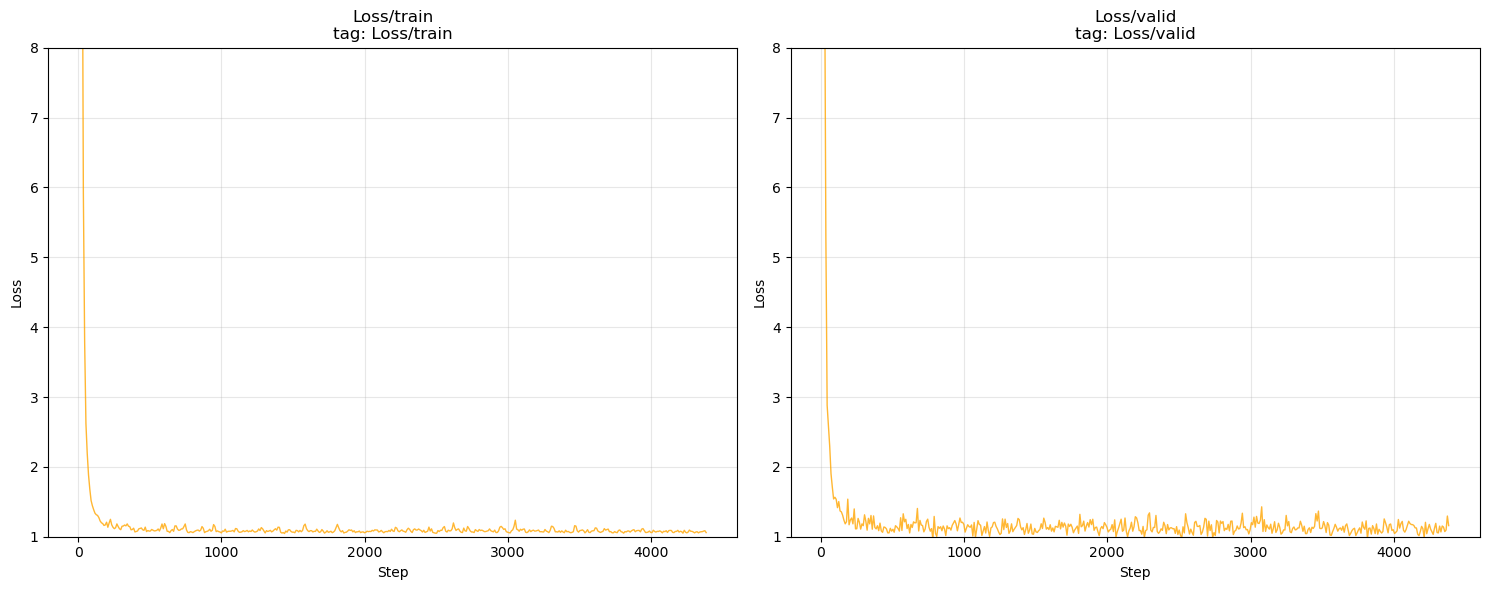


训练统计:
  训练损失: 13.0876 → 1.0593
  验证损失: 11.8025 → 1.1594


In [13]:
import matplotlib.pyplot as plt
import os
import glob
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def plot_tensorboard_logs_simple():
    """简化版：只绘制两个图，类似示范图格式"""
    
    # 查找所有日志文件
    log_files = glob.glob('./runs/**/events.out.tfevents.*', recursive=True)
    
    if not log_files:
        print("没有找到tensorboard日志文件")
        return
    
    print(f"找到 {len(log_files)} 个日志文件")
    
    # 使用最新的日志文件
    latest_log = max(log_files, key=os.path.getmtime)
    print(f"使用日志文件: {latest_log}")
    
    try:
        # 加载日志
        ea = EventAccumulator(latest_log)
        ea.Reload()
        
        # 提取训练和验证损失
        train_loss_data = ea.Scalars('Loss/train')
        valid_loss_data = ea.Scalars('Loss/valid')
        
        # 提取数据
        train_steps = [x.step for x in train_loss_data]
        train_losses = [x.value for x in train_loss_data]
        
        valid_steps = [x.step for x in valid_loss_data] 
        valid_losses = [x.value for x in valid_loss_data]
        
        # 找到有效训练区间（跳过初始极高损失）
        train_start_idx = next((i for i, loss in enumerate(train_losses) if loss < 20), 0)
        valid_start_idx = next((i for i, loss in enumerate(valid_losses) if loss < 20), 0)
        
        # 截取有效数据
        train_steps_clipped = train_steps[train_start_idx:]
        train_losses_clipped = train_losses[train_start_idx:]
        valid_steps_clipped = valid_steps[valid_start_idx:]
        valid_losses_clipped = valid_losses[valid_start_idx:]
        
        # 只绘制两个图 - 类似示范图的风格
        plt.figure(figsize=(8, 3))
        
        # 训练损失
        plt.subplot(1, 2, 1)
        plt.plot(train_steps_clipped, train_losses_clipped, 'orange', alpha=0.8, linewidth=1)
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title('Loss/train\ntag: Loss/train', fontsize=12)
        plt.ylim(1, 8)  # 设置Y轴范围
        plt.grid(True, alpha=0.3)
        
        # 验证损失
        plt.subplot(1, 2, 2)
        plt.plot(valid_steps_clipped, valid_losses_clipped, 'orange', alpha=0.8, linewidth=1)
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title('Loss/valid\ntag: Loss/valid', fontsize=12)
        plt.ylim(1, 8)  # 设置Y轴范围
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 打印简要统计信息
        print(f"\n训练统计:")
        print(f"  训练损失: {train_losses_clipped[0]:.4f} → {train_losses_clipped[-1]:.4f}")
        print(f"  验证损失: {valid_losses_clipped[0]:.4f} → {valid_losses_clipped[-1]:.4f}")
        
    except Exception as e:
        print(f"读取日志文件时出错: {e}")

# 运行简化版函数
plot_tensorboard_logs_simple()

In [ ]:
# 1. 画损失曲线
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Training Curves')

# 2. 画预测结果
plt.subplot(1, 2, 2)
model.load_state_dict(torch.load(config['save_path']))
model.eval()
val_preds = []
with torch.no_grad():
    for x, y in valid_loader:
        val_preds.append(model(x.to(device)).cpu().numpy())
val_preds = np.concatenate(val_preds)

plt.scatter(y_valid, val_preds, alpha=0.6)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('GT vs Prediction')
plt.show()

# Testing
The predictions of your model on testing set will be stored at `pred.csv`.

In [14]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
save_pred(preds, 'pred.csv')

D:\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 5/5 [00:00<00:00, 546.39it/s]


# Reference
This notebook uses code written by Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)